<a href="https://colab.research.google.com/github/KesavaSravan/Economic-Dispatch-with-Lagrangian-Relaxation-Method/blob/main/Product_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Use wget to download the dataset
!wget https://storage.googleapis.com/open_source_datasets/product_detection_from_packshots.tar.gz

--2024-01-27 08:21:57--  https://storage.googleapis.com/open_source_datasets/product_detection_from_packshots.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947415270 (904M) [application/gzip]
Saving to: ‘product_detection_from_packshots.tar.gz’

product_detection_f 100%[===================>] 903.53M  66.8MB/s    in 11s     

2024-01-27 08:22:08 (84.5 MB/s) - ‘product_detection_from_packshots.tar.gz’ saved [947415270/947415270]



In [2]:
# Extract the contents of the tar.gz file
!tar -xzvf product_detection_from_packshots.tar.gz

product_detection_from_packshots/shelf_images/db3061.jpg
product_detection_from_packshots/product_images/qr190.jpg
product_detection_from_packshots/shelf_images/db2012.jpg
product_detection_from_packshots/shelf_images/db1670.jpg
product_detection_from_packshots/shelf_images/db2461.jpg
product_detection_from_packshots/shelf_images/db722.jpg
product_detection_from_packshots/shelf_images/db1861.jpg
product_detection_from_packshots/shelf_images/db2652.jpg
product_detection_from_packshots/shelf_images/db1412.jpg
product_detection_from_packshots/shelf_images/db913.jpg
product_detection_from_packshots/shelf_images/db2749.jpg
product_detection_from_packshots/shelf_images/db2203.jpg
product_detection_from_packshots/shelf_images/db783.jpg
product_detection_from_packshots/shelf_images/db1603.jpg
product_detection_from_packshots/shelf_images/db1024.jpg
product_detection_from_packshots/shelf_images/db2073.jpg
product_detection_from_packshots/shelf_images/db974.jpg
product_detection_from_packshots/s

In [3]:
import os
import cv2
import re

# Define the paths to the shelf_images and product_images folders
shelf_images_folder = "product_detection_from_packshots/shelf_images"
product_images_folder = "product_detection_from_packshots/product_images"

# Function to read images from a folder in ascending order based on numbers in the filenames
def read_images_from_folder_sorted(folder_path):
    images = []
    # Get a list of image filenames in the folder
    filenames = os.listdir(folder_path)

    # Sort filenames based on the numeric part
    filenames.sort(key=lambda x: int(re.search(r'\d+', x).group()))

    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            # Read the image using OpenCV
            img = cv2.imread(img_path)
            images.append(img)
    return images

# Read images from shelf_images folder in ascending order
shelf_images = read_images_from_folder_sorted(shelf_images_folder)

# Read images from product_images folder in ascending order
product_images = read_images_from_folder_sorted(product_images_folder)

# Print the number of images in each folder
print("Number of shelf images:", len(shelf_images))
print("Number of product images:", len(product_images))


Number of shelf images: 3153
Number of product images: 300


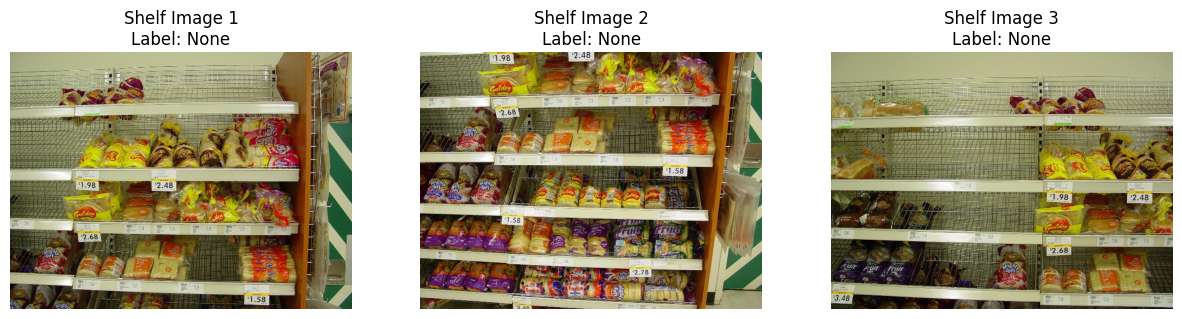

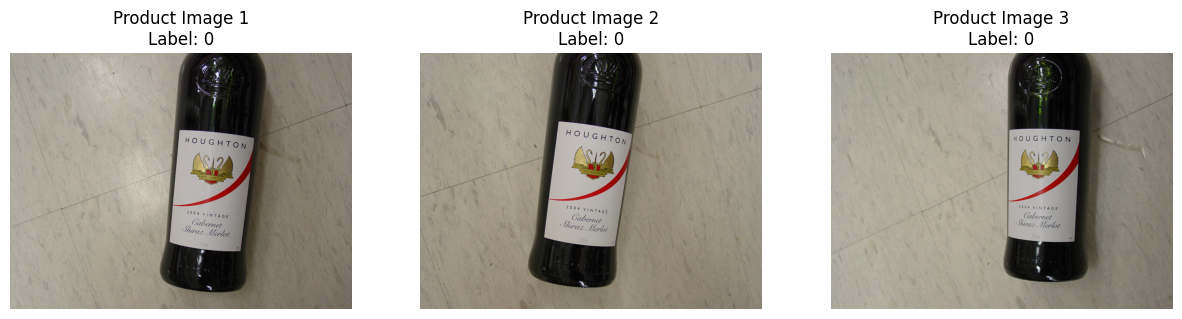

In [4]:
import matplotlib.pyplot as plt
# Assign labels to product images (0 to 99)
labels = [i // 3 for i in range(300)]

# Visualize a few images from each category with labels
def visualize_images(images, category_name, category_labels):
    plt.figure(figsize=(15, 6))
    for i in range(min(3, len(images))):  # Display up to 3 images
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"{category_name} Image {i + 1}\nLabel: {category_labels[i]}")
        plt.axis("off")
    plt.show()

# Visualize shelf images with labels
visualize_images(shelf_images, "Shelf", [None] * 3)  # No labels for shelf images

# Visualize product images with labels
visualize_images(product_images, "Product", labels[:3])

In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
def preprocess_images(images, labels, target_size=(256, 256), crop_size=(1200, 1200)):
    processed_images = []
    for img in images:
        # Resize the image to the target size
        img_resized = cv2.resize(img, target_size)

        # Crop the image to the specified size
        h, w = crop_size
        center_h, center_w = img_resized.shape[0] // 2, img_resized.shape[1] // 2
        crop_img = img_resized[center_h - h // 2: center_h + h // 2, center_w - w // 2: center_w + w // 2]

        # Normalize pixel values
        crop_img = crop_img.astype(np.float32) / 255.0
        processed_images.append(crop_img)

    return np.array(processed_images), np.array(labels)
# Assuming 'product_images' and 'labels' are available
processed_images, labels = preprocess_images(product_images, labels)

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    processed_images, labels, test_size=0.2, random_state=42
)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential

# Create a base model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create the final model for object detection
num_classes = 100  # Adjust this based on your problem
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
8/8 [==============================] - 10s 484ms/step - loss: 4.9585 - accuracy: 0.0417 - val_loss: 4.6909 - val_accuracy: 0.1333
Epoch 2/10
8/8 [==============================] - 1s 81ms/step - loss: 3.5096 - accuracy: 0.3750 - val_loss: 4.1039 - val_accuracy: 0.1833
Epoch 3/10
8/8 [==============================] - 1s 73ms/step - loss: 2.4663 - accuracy: 0.7167 - val_loss: 3.4304 - val_accuracy: 0.4833
Epoch 4/10
8/8 [==============================] - 1s 72ms/step - loss: 1.6386 - accuracy: 0.9083 - val_loss: 2.7941 - val_accuracy: 0.6500
Epoch 5/10
8/8 [==============================] - 1s 75ms/step - loss: 1.0576 - accuracy: 0.9792 - val_loss: 2.3698 - val_accuracy: 0.6833
Epoch 6/10
8/8 [==============================] - 1s 76ms/step - loss: 0.6868 - accuracy: 0.9958 - val_loss: 2.0773 - val_accuracy: 0.7500
Epoch 7/10
8/8 [==============================] - 1s 76ms/step - loss: 0.4593 - accuracy: 1.0000 - va

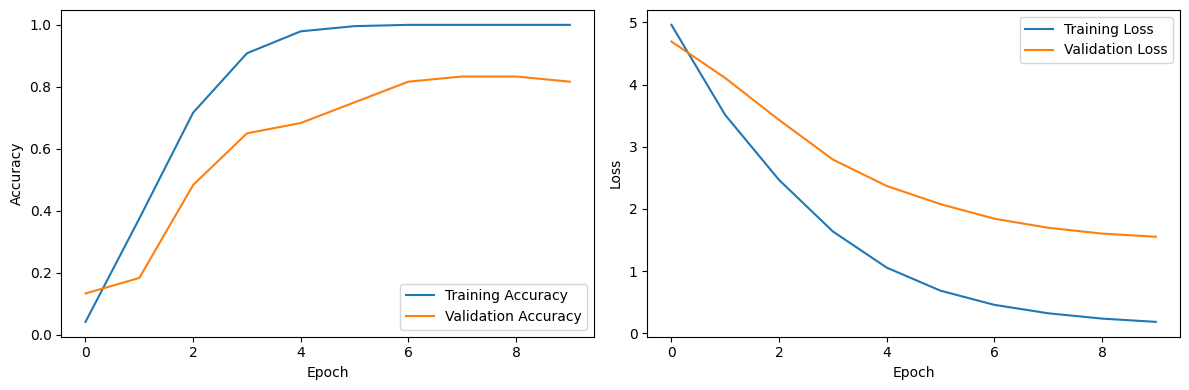

In [7]:
# Plotting the accuracy graph
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Get model summary
model.summary()
# Save the model to an H5 file
model.save("product_detection_model.h5")
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"\nTesting Accuracy: {test_accuracy * 100:.2f}%")
# Evaluate the model on the test set
test_predictions = model.predict(test_images)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)
# Display classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 2386084 (9.10 MB)
Trainable params: 128100 (500.39 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 70ms/step - loss: 1.5534 - accuracy: 0.8167

Testing Accuracy: 81.67%
2/2 [==============================] - 2s 88ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         0
          11       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         1
          21       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         1
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [9]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 4.8 MB/s eta 0:00:00


In [12]:
!git clone https://github.com/ultralytics/yolov5  # clone
!cd yolov5
!pip install -r /content/yolov5/requirements.txt  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.2.0 which is incompatible.


In [3]:
!python /content/yolov5/detect.py --help
!python /content/yolov5/detect.py --source /content/product_detection_from_packshots/shelf_images --img-size 896 --save-txt --save-conf --project /content/txtfiles

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE] [--data DATA]
                 [--imgsz IMGSZ [IMGSZ ...]] [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img] [--save-txt] [--save-csv]
                 [--save-conf] [--save-crop] [--nosave] [--classes CLASSES [CLASSES ...]]
                 [--agnostic-nms] [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS] [--hide-labels]
                 [--hide-conf] [--half] [--dnn] [--vid-stride VID_STRIDE]

options:
  -h, --help            show this help message and exit
  --weights WEIGHTS [WEIGHTS ...]
                        model path or triton URL
  --source SOURCE       file/dir/URL/glob/screen/0(webcam)
  --data DATA           (optional) dataset.yaml path
  --imgsz IMGSZ [IMGSZ ...], --img IMGSZ [IMGSZ ...], --img-size IMGSZ [IMGSZ ...]
                        infere

In [15]:
import os
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

# Function to form a line in the required format
def form_line(id1, id2, x_min, y_min, x_max, y_max):
    return f"{id1}, {id2}, {x_min}, {y_min}, {x_max}, {y_max}\n"

# Path configurations
txt_path = '/content/txtfiles/exp/labels'
img_path = 'product_detection_from_packshots/shelf_images'
soln_1_path = 'solution_1.txt'
soln_2_path = 'solution_2.txt'
weight_file = 'product_detection_model.h5'

# Fetch list of text files and images
txt_files = [file_ for file_ in natsorted(os.listdir(txt_path)) if file_.endswith('.txt')]
img_files = [file_ for file_ in natsorted(os.listdir(img_path)) if file_.endswith('.jpg')]

print(f'Text files available: {len(txt_files)}')
print(f'Shelf image files available: {len(img_files)}')

# Load the model
model = tf.keras.models.load_model(weight_file)

# Initialize lines for solution 1 and solution 2
lines_1 = ''
lines_2 = ''

# define lines string for solution 1
lines_1 = ''
# define lines string for solution 2
lines_2 = ''

for txt in tqdm(txt_files):
  id = txt.split('.txt')[0]
  demo_txt = os.path.join(txt_path, txt_files[1])
  demo_img = os.path.join(img_path, id+'.jpg')

  img_shape = np.flip(np.array(plt.imread(demo_img).shape[:2]))
  #print(img_shape)
  img = plt.imread(demo_img)

  with open(demo_txt, 'r') as demo:
    for line in demo.readlines():
      (x_, y_, w_, h_, confidence) = line.split()[1:]

      # x, y, w, h are obtained from deteted record
      x = int(float(x_)*float(img_shape[0]))
      y = int(float(y_)*float(img_shape[1]))
      w = int(float(w_)*float(img_shape[0]))
      h = int(float(h_)*float(img_shape[1]))

      # x_min, y_min (top left corner of image)
      x1 = int(x - (w/2))
      y1 = int(y - (h/2))
      # as in image the dimension is flipped i.e y:x
      img_ = np.array(img[y1:y1+h, x1:x1+w])

      # resize image to (1, 256,256, 3)
      img_res = tf.keras.preprocessing.image.smart_resize(img_, size = (256,256), interpolation='bicubic')
      img_res = img_res - img_res.min()
      img_res = img_res/(img_res.max() - img_res.min())
      img_res = np.expand_dims(img_res, axis = 0)

      # define model prediction
      y_pred = model.predict(img_res)
      y_pred = np.argmax(y_pred, 1)
      # evaluate box parameters
      x_min = x1
      y_min = y1
      x_max = x1 + w
      y_max = y1 + h

      # fetches the serial no of shelf image
      id_key = id.split('db')[1]
      #print(id_key)
      # line for soln1, where input is product image
      lines_1 += form_line(y_pred[0], id_key, x_min, y_min, x_max, y_max)
      # here input is only shelf image
      lines_2 += form_line(id_key, y_pred[0], x_min, y_min, x_max, y_max)

#Writing in Soluction_1
if not os.path.isfile(soln_1_path):
  f_1 = open(soln_1_path, 'x')
  f_1.close()

with open(soln_1_path, 'w') as s1:
  s1.write(lines_1)

#Writing in Soluction_2
if not os.path.isfile(soln_2_path):
  f_2 = open(soln_2_path, 'x')
  f_2.close()

with open(soln_2_path, 'w') as s2:
  s2.write(lines_2)

Text files available: 2750
Shelf image files available: 3153


  0%|          | 0/2750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 1/2750 [00:01<1:28:22,  1.93s/it]

1/1 [==============================] - 0s 22ms/step


  0%|          | 2/2750 [00:02<56:08,  1.23s/it]  

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/2750 [00:03<41:59,  1.09it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 4/2750 [00:03<35:37,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 5/2750 [00:04<32:27,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 6/2750 [00:04<30:17,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 7/2750 [00:05<28:46,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 8/2750 [00:06<27:49,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 9/2750 [00:06<27:11,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 10/2750 [00:07<26:56,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 11/2750 [00:07<26:53,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 12/2750 [00:08<26:45,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 13/2750 [00:08<26:37,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 14/2750 [00:09<26:35,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 15/2750 [00:10<26:05,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 16/2750 [00:10<26:21,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 17/2750 [00:11<26:14,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 18/2750 [00:11<26:15,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 19/2750 [00:12<26:14,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 20/2750 [00:13<29:08,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 21/2750 [00:13<31:13,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 22/2750 [00:14<30:12,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 23/2750 [00:15<28:58,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 24/2750 [00:15<27:53,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 25/2750 [00:16<27:15,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 26/2750 [00:16<26:57,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 27/2750 [00:17<27:04,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 28/2750 [00:18<26:40,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 29/2750 [00:18<26:11,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 30/2750 [00:19<25:58,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 31/2750 [00:19<25:55,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 32/2750 [00:20<25:50,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 33/2750 [00:20<25:50,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 34/2750 [00:21<25:41,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 35/2750 [00:22<25:48,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 36/2750 [00:22<25:36,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 37/2750 [00:23<25:41,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 38/2750 [00:23<25:38,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 39/2750 [00:24<26:26,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 40/2750 [00:25<29:09,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 41/2750 [00:25<31:27,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 42/2750 [00:26<29:52,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 43/2750 [00:27<28:34,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 44/2750 [00:27<27:37,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 45/2750 [00:28<27:19,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 46/2750 [00:28<26:36,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 47/2750 [00:29<26:30,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 48/2750 [00:29<26:13,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 49/2750 [00:30<26:08,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 50/2750 [00:31<31:30,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 51/2750 [00:32<30:23,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 52/2750 [00:32<30:08,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 53/2750 [00:33<29:53,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 54/2750 [00:34<29:16,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 55/2750 [00:34<28:32,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 56/2750 [00:35<28:27,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 57/2750 [00:35<27:58,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 58/2750 [00:36<31:09,  1.44it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 59/2750 [00:37<33:14,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 60/2750 [00:38<32:00,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 61/2750 [00:38<30:20,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 62/2750 [00:39<29:40,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 63/2750 [00:40<28:57,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 64/2750 [00:40<28:37,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 65/2750 [00:41<28:10,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 66/2750 [00:41<27:53,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 67/2750 [00:42<27:41,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 68/2750 [00:43<27:44,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 69/2750 [00:43<27:20,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 70/2750 [00:44<27:05,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 71/2750 [00:44<26:48,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 72/2750 [00:45<26:57,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 73/2750 [00:46<27:09,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 74/2750 [00:46<27:07,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 75/2750 [00:47<26:46,  1.66it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 76/2750 [00:48<28:07,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 77/2750 [00:48<30:14,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 78/2750 [00:49<31:26,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 79/2750 [00:50<29:49,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 80/2750 [00:50<28:59,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 81/2750 [00:51<28:10,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 82/2750 [00:51<27:42,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 83/2750 [00:52<27:17,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 84/2750 [00:53<27:06,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 85/2750 [00:53<27:20,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 86/2750 [00:54<27:01,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 87/2750 [00:54<26:49,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 88/2750 [00:55<26:42,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 89/2750 [00:56<26:44,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 90/2750 [00:56<26:49,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 91/2750 [00:57<26:25,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 92/2750 [00:57<26:02,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 93/2750 [00:58<25:58,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 94/2750 [00:59<25:56,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 95/2750 [00:59<27:53,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 96/2750 [01:00<30:08,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 97/2750 [01:01<31:27,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 98/2750 [01:02<30:04,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 99/2750 [01:02<28:52,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 100/2750 [01:03<28:31,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 101/2750 [01:03<27:47,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 102/2750 [01:04<27:45,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 103/2750 [01:05<27:39,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 104/2750 [01:05<27:02,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 105/2750 [01:06<26:38,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 106/2750 [01:06<26:19,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 107/2750 [01:07<26:24,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 108/2750 [01:08<26:14,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 109/2750 [01:08<25:54,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 110/2750 [01:09<25:53,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 111/2750 [01:09<25:38,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 112/2750 [01:10<25:51,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 113/2750 [01:10<25:41,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 114/2750 [01:11<27:22,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 115/2750 [01:12<29:44,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 116/2750 [01:13<30:45,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 117/2750 [01:13<29:02,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 118/2750 [01:14<28:23,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 119/2750 [01:14<27:53,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 120/2750 [01:15<27:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 121/2750 [01:16<27:11,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 122/2750 [01:16<26:45,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 123/2750 [01:17<26:22,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 124/2750 [01:17<26:02,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 125/2750 [01:18<25:56,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 126/2750 [01:19<25:50,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 127/2750 [01:19<25:47,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 128/2750 [01:20<26:09,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 129/2750 [01:20<26:02,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 130/2750 [01:21<26:05,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 131/2750 [01:22<26:07,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 132/2750 [01:22<25:59,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 133/2750 [01:23<27:37,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 134/2750 [01:24<29:33,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 135/2750 [01:25<30:54,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 136/2750 [01:25<29:22,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 137/2750 [01:26<28:01,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 138/2750 [01:26<27:12,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 139/2750 [01:27<26:40,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 140/2750 [01:27<26:27,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 141/2750 [01:28<26:09,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 142/2750 [01:29<25:35,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 143/2750 [01:29<25:36,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 144/2750 [01:30<25:24,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 145/2750 [01:30<25:13,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 146/2750 [01:31<25:06,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 147/2750 [01:31<25:15,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 148/2750 [01:32<25:20,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 149/2750 [01:33<25:36,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 150/2750 [01:33<25:47,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 151/2750 [01:34<25:48,  1.68it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 152/2750 [01:35<26:28,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 153/2750 [01:35<28:59,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 154/2750 [01:36<30:41,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 155/2750 [01:37<29:07,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 156/2750 [01:37<27:58,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 157/2750 [01:38<26:59,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 158/2750 [01:38<26:17,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 159/2750 [01:39<25:42,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 160/2750 [01:40<25:28,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 161/2750 [01:40<25:15,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 162/2750 [01:41<25:21,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 163/2750 [01:41<25:30,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 164/2750 [01:42<25:27,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 165/2750 [01:43<25:27,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 166/2750 [01:43<25:19,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 167/2750 [01:44<26:55,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 168/2750 [01:45<29:09,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 169/2750 [01:45<30:19,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 170/2750 [01:46<29:03,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 171/2750 [01:47<29:55,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 172/2750 [01:48<31:14,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 173/2750 [01:48<30:53,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 174/2750 [01:49<29:16,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 175/2750 [01:49<27:43,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 176/2750 [01:50<27:05,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 177/2750 [01:51<26:18,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 178/2750 [01:51<25:43,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 179/2750 [01:52<25:49,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 180/2750 [01:52<25:13,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 181/2750 [01:53<25:13,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 182/2750 [01:53<25:09,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 183/2750 [01:54<25:00,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 184/2750 [01:55<24:56,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 185/2750 [01:55<24:51,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 186/2750 [01:56<24:30,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 187/2750 [01:56<24:57,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 188/2750 [01:57<25:04,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 189/2750 [01:58<24:58,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 190/2750 [01:58<26:24,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 191/2750 [01:59<28:33,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 192/2750 [02:00<30:02,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 193/2750 [02:01<33:48,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 194/2750 [02:01<31:43,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 195/2750 [02:02<30:22,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 196/2750 [02:03<29:15,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 197/2750 [02:03<28:55,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 198/2750 [02:04<28:22,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 199/2750 [02:05<27:45,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 200/2750 [02:05<27:28,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 201/2750 [02:06<26:52,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 202/2750 [02:06<26:24,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 203/2750 [02:07<26:42,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 204/2750 [02:08<26:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 205/2750 [02:08<26:31,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 206/2750 [02:09<26:20,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 207/2750 [02:10<25:59,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 208/2750 [02:10<27:44,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 209/2750 [02:11<29:50,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 210/2750 [02:12<30:36,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 211/2750 [02:13<29:18,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 212/2750 [02:13<28:25,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 213/2750 [02:14<27:39,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 214/2750 [02:14<27:03,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 215/2750 [02:15<26:18,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 216/2750 [02:16<26:01,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 217/2750 [02:16<25:55,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 218/2750 [02:17<25:38,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 219/2750 [02:17<25:28,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 220/2750 [02:18<25:27,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 221/2750 [02:19<25:27,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 222/2750 [02:19<25:30,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 223/2750 [02:20<25:34,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 224/2750 [02:20<25:14,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 225/2750 [02:21<25:08,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 226/2750 [02:22<25:21,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 227/2750 [02:22<27:37,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 228/2750 [02:23<29:59,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 229/2750 [02:24<29:41,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 230/2750 [02:24<28:12,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 231/2750 [02:25<27:55,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 232/2750 [02:26<27:09,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 233/2750 [02:26<26:29,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 234/2750 [02:27<26:08,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 235/2750 [02:28<25:33,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 236/2750 [02:28<25:36,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 237/2750 [02:29<25:34,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 238/2750 [02:29<25:36,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 239/2750 [02:30<25:30,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 240/2750 [02:31<25:47,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 241/2750 [02:31<25:35,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 242/2750 [02:32<25:28,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 243/2750 [02:32<25:10,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 244/2750 [02:33<25:08,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 245/2750 [02:34<26:22,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 246/2750 [02:34<28:18,  1.47it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 247/2750 [02:35<30:35,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 248/2750 [02:36<29:43,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 249/2750 [02:37<28:08,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 250/2750 [02:37<27:01,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 251/2750 [02:38<26:32,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 252/2750 [02:38<25:52,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 253/2750 [02:39<25:42,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 254/2750 [02:40<25:29,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 255/2750 [02:40<25:11,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 256/2750 [02:41<25:05,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 257/2750 [02:41<25:09,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 258/2750 [02:42<24:56,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 259/2750 [02:43<25:00,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 260/2750 [02:43<24:39,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 261/2750 [02:44<24:48,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 262/2750 [02:44<24:51,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 263/2750 [02:45<24:54,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 264/2750 [02:46<25:42,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 265/2750 [02:46<28:06,  1.47it/s]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 266/2750 [02:47<30:13,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 267/2750 [02:48<28:39,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 268/2750 [02:48<27:17,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 269/2750 [02:49<26:23,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 270/2750 [02:50<26:08,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 271/2750 [02:50<25:43,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 272/2750 [02:51<25:26,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 273/2750 [02:52<25:35,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 274/2750 [02:52<25:23,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 275/2750 [02:53<25:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 276/2750 [02:53<25:21,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 277/2750 [02:54<25:24,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 278/2750 [02:55<24:55,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 279/2750 [02:55<24:49,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 280/2750 [02:56<25:04,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 281/2750 [02:56<24:43,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 282/2750 [02:57<24:36,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 283/2750 [02:58<25:40,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 284/2750 [02:58<27:55,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 285/2750 [02:59<29:49,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 286/2750 [03:00<28:31,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 287/2750 [03:00<27:02,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 288/2750 [03:01<26:19,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 289/2750 [03:02<25:55,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 290/2750 [03:02<25:24,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 291/2750 [03:03<25:20,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 292/2750 [03:03<24:50,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 293/2750 [03:04<25:11,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 294/2750 [03:05<25:01,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 295/2750 [03:05<25:15,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 296/2750 [03:06<25:16,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 297/2750 [03:07<24:59,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 298/2750 [03:07<24:40,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 299/2750 [03:08<24:29,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 300/2750 [03:08<24:28,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 301/2750 [03:09<24:38,  1.66it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 302/2750 [03:10<26:03,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 303/2750 [03:10<28:23,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 304/2750 [03:11<30:04,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 305/2750 [03:12<28:31,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 306/2750 [03:13<27:14,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 307/2750 [03:13<26:28,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 308/2750 [03:14<25:33,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 309/2750 [03:14<25:10,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 310/2750 [03:15<24:55,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 311/2750 [03:16<24:43,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 312/2750 [03:16<24:44,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 313/2750 [03:17<24:40,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 314/2750 [03:17<24:37,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 315/2750 [03:18<24:11,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 316/2750 [03:19<24:22,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 317/2750 [03:19<24:08,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 318/2750 [03:20<24:09,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 319/2750 [03:20<24:19,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 320/2750 [03:21<24:29,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 321/2750 [03:22<25:54,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 322/2750 [03:23<28:34,  1.42it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 323/2750 [03:23<29:56,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 324/2750 [03:24<28:13,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 325/2750 [03:25<26:52,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 326/2750 [03:25<25:50,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 327/2750 [03:26<25:17,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 328/2750 [03:26<24:50,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 329/2750 [03:27<24:46,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 330/2750 [03:27<24:36,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 331/2750 [03:28<24:40,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 332/2750 [03:29<24:40,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 333/2750 [03:29<24:41,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 334/2750 [03:30<29:20,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 335/2750 [03:31<28:40,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 336/2750 [03:32<28:19,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 337/2750 [03:32<27:38,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 338/2750 [03:33<27:11,  1.48it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 339/2750 [03:34<29:14,  1.37it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 340/2750 [03:35<32:00,  1.25it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 341/2750 [03:36<34:54,  1.15it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 342/2750 [03:37<34:56,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 343/2750 [03:37<33:30,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 344/2750 [03:38<31:49,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 345/2750 [03:39<30:04,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 346/2750 [03:39<28:48,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 347/2750 [03:40<27:47,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 348/2750 [03:41<27:15,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 349/2750 [03:41<26:41,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 350/2750 [03:42<26:24,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 351/2750 [03:43<26:02,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 352/2750 [03:43<26:01,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 353/2750 [03:44<25:47,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 354/2750 [03:45<25:25,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 355/2750 [03:45<25:12,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 356/2750 [03:46<26:21,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 357/2750 [03:47<28:55,  1.38it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 358/2750 [03:48<30:57,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 359/2750 [03:48<29:12,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 360/2750 [03:49<27:57,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 361/2750 [03:50<27:12,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 362/2750 [03:50<26:42,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 363/2750 [03:51<26:02,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 364/2750 [03:51<25:34,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 365/2750 [03:52<25:31,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 366/2750 [03:53<25:20,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 367/2750 [03:53<25:03,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 368/2750 [03:54<25:02,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 369/2750 [03:55<24:55,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 370/2750 [03:55<24:58,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 371/2750 [03:56<24:48,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 372/2750 [03:56<25:05,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 373/2750 [03:57<24:48,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 374/2750 [03:58<24:54,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 375/2750 [03:59<27:41,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 376/2750 [03:59<29:54,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 377/2750 [04:00<28:38,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 378/2750 [04:01<27:11,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 379/2750 [04:01<26:32,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 380/2750 [04:02<25:54,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 381/2750 [04:03<25:31,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 382/2750 [04:03<25:00,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 383/2750 [04:04<24:52,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 384/2750 [04:04<24:29,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 385/2750 [04:05<24:31,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 386/2750 [04:06<24:17,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 387/2750 [04:06<24:13,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 388/2750 [04:07<24:18,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 389/2750 [04:08<24:33,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 390/2750 [04:08<24:35,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 391/2750 [04:09<24:33,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 392/2750 [04:09<24:18,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 393/2750 [04:10<26:15,  1.50it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 394/2750 [04:11<28:21,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 395/2750 [04:12<29:18,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 396/2750 [04:12<27:38,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 397/2750 [04:13<26:42,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 398/2750 [04:14<25:55,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 399/2750 [04:14<25:17,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 400/2750 [04:15<24:46,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 401/2750 [04:16<24:34,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 402/2750 [04:16<24:18,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 403/2750 [04:17<24:04,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 404/2750 [04:17<24:09,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 405/2750 [04:18<24:10,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 406/2750 [04:19<24:04,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 407/2750 [04:19<24:04,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 408/2750 [04:20<23:57,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 409/2750 [04:20<23:54,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 410/2750 [04:21<24:08,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 411/2750 [04:22<24:18,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 412/2750 [04:23<27:10,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 413/2750 [04:23<29:54,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 414/2750 [04:24<29:13,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 415/2750 [04:25<27:50,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 416/2750 [04:25<26:33,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 417/2750 [04:26<25:36,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 418/2750 [04:27<25:29,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 419/2750 [04:27<24:55,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 420/2750 [04:28<24:21,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 421/2750 [04:28<24:11,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 422/2750 [04:29<23:46,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 423/2750 [04:30<24:06,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 424/2750 [04:30<24:03,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 425/2750 [04:31<23:45,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 426/2750 [04:32<23:53,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 427/2750 [04:32<23:52,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 428/2750 [04:33<23:54,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 429/2750 [04:33<23:55,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 430/2750 [04:34<25:38,  1.51it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 431/2750 [04:35<28:01,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 432/2750 [04:36<28:27,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 433/2750 [04:36<26:38,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 434/2750 [04:37<25:45,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 435/2750 [04:38<25:05,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 436/2750 [04:38<24:38,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 437/2750 [04:39<24:26,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 438/2750 [04:39<24:05,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 439/2750 [04:40<24:03,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 440/2750 [04:41<23:52,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 441/2750 [04:41<23:40,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 442/2750 [04:42<23:34,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 443/2750 [04:43<23:27,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 444/2750 [04:43<23:33,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 445/2750 [04:44<23:17,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 446/2750 [04:44<23:26,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 447/2750 [04:45<23:33,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 448/2750 [04:46<23:33,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 449/2750 [04:46<26:16,  1.46it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 450/2750 [04:47<28:02,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 451/2750 [04:48<28:07,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 452/2750 [04:49<26:44,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 453/2750 [04:49<25:32,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 454/2750 [04:50<24:45,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 455/2750 [04:50<24:29,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 456/2750 [04:51<24:13,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 457/2750 [04:52<23:44,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 458/2750 [04:52<23:33,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 459/2750 [04:53<23:20,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 460/2750 [04:53<23:18,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 461/2750 [04:54<23:00,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 462/2750 [04:55<23:06,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 463/2750 [04:55<23:12,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 464/2750 [04:56<23:15,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 465/2750 [04:57<23:24,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 466/2750 [04:57<23:20,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 467/2750 [04:58<23:50,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 468/2750 [04:59<26:29,  1.44it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 469/2750 [05:00<28:24,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 470/2750 [05:00<27:02,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 471/2750 [05:01<25:37,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 472/2750 [05:01<24:55,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 473/2750 [05:02<28:58,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 474/2750 [05:03<27:46,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 475/2750 [05:04<27:01,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 476/2750 [05:04<26:13,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 477/2750 [05:05<26:04,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 478/2750 [05:06<25:52,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 479/2750 [05:06<25:25,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 480/2750 [05:07<25:13,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 481/2750 [05:08<25:05,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 482/2750 [05:08<25:26,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 483/2750 [05:09<25:30,  1.48it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 484/2750 [05:10<25:26,  1.48it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 485/2750 [05:11<27:49,  1.36it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 486/2750 [05:11<29:49,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 487/2750 [05:12<28:16,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 488/2750 [05:13<26:58,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 489/2750 [05:13<25:57,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 490/2750 [05:14<25:27,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 491/2750 [05:15<25:15,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 492/2750 [05:15<24:43,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 493/2750 [05:16<24:26,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 494/2750 [05:17<24:09,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 495/2750 [05:17<24:00,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 496/2750 [05:18<23:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 497/2750 [05:18<23:33,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 498/2750 [05:19<23:33,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 499/2750 [05:20<23:38,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 500/2750 [05:20<23:39,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 501/2750 [05:21<23:47,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 502/2750 [05:22<24:19,  1.54it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 503/2750 [05:23<26:48,  1.40it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 504/2750 [05:23<28:28,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 505/2750 [05:24<27:35,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 506/2750 [05:25<26:18,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 507/2750 [05:25<25:16,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 508/2750 [05:26<24:50,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 509/2750 [05:27<26:34,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 510/2750 [05:28<28:24,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 511/2750 [05:28<29:00,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 512/2750 [05:29<27:02,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 513/2750 [05:30<26:15,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 514/2750 [05:30<25:24,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 515/2750 [05:31<24:47,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 516/2750 [05:32<24:14,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 517/2750 [05:32<24:19,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 518/2750 [05:33<24:02,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 519/2750 [05:34<23:58,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 520/2750 [05:34<26:14,  1.42it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 521/2750 [05:35<28:00,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 522/2750 [05:36<27:33,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 523/2750 [05:37<26:18,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 524/2750 [05:37<25:17,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 525/2750 [05:38<24:42,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 526/2750 [05:38<24:28,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 527/2750 [05:39<23:56,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 528/2750 [05:40<23:48,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 529/2750 [05:40<23:30,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 530/2750 [05:41<23:18,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 531/2750 [05:42<23:22,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 532/2750 [05:42<23:18,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 533/2750 [05:43<23:19,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 534/2750 [05:43<23:06,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 535/2750 [05:44<23:04,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 536/2750 [05:45<22:54,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 537/2750 [05:45<22:36,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 538/2750 [05:46<24:29,  1.50it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 539/2750 [05:47<26:28,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 540/2750 [05:48<27:50,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 541/2750 [05:48<26:25,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 542/2750 [05:49<25:14,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 543/2750 [05:50<24:35,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 544/2750 [05:50<23:52,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 545/2750 [05:51<23:39,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 546/2750 [05:51<23:12,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 547/2750 [05:52<22:47,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 548/2750 [05:53<22:53,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 549/2750 [05:53<22:45,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 550/2750 [05:54<22:55,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 551/2750 [05:55<22:50,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 552/2750 [05:55<22:42,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 553/2750 [05:56<22:35,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 554/2750 [05:56<22:24,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 555/2750 [05:57<22:45,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 556/2750 [05:58<23:02,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 557/2750 [05:59<25:26,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 558/2750 [05:59<27:28,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 559/2750 [06:00<26:37,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 560/2750 [06:01<25:18,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 561/2750 [06:01<24:27,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 562/2750 [06:02<23:58,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 563/2750 [06:03<23:39,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 564/2750 [06:03<23:25,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 565/2750 [06:04<23:08,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 566/2750 [06:04<23:03,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 567/2750 [06:05<23:13,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 568/2750 [06:06<22:59,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 569/2750 [06:06<22:45,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 570/2750 [06:07<22:33,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 571/2750 [06:08<22:22,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 572/2750 [06:08<22:17,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 573/2750 [06:09<22:42,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 574/2750 [06:09<22:34,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 575/2750 [06:10<24:18,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 576/2750 [06:11<26:37,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 577/2750 [06:12<27:06,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 578/2750 [06:12<25:28,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 579/2750 [06:13<24:28,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 580/2750 [06:14<24:04,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 581/2750 [06:14<23:21,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 582/2750 [06:15<23:12,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 583/2750 [06:16<22:48,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 584/2750 [06:16<22:33,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 585/2750 [06:17<22:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 586/2750 [06:17<22:14,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 587/2750 [06:18<22:10,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 588/2750 [06:19<22:06,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 589/2750 [06:19<22:01,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 590/2750 [06:20<22:10,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 591/2750 [06:20<21:52,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 592/2750 [06:21<21:53,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 593/2750 [06:22<21:55,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 594/2750 [06:23<25:05,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 595/2750 [06:23<26:57,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 596/2750 [06:24<26:16,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 597/2750 [06:25<24:52,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 598/2750 [06:25<23:56,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 599/2750 [06:26<23:21,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 600/2750 [06:27<22:57,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 601/2750 [06:27<23:26,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 602/2750 [06:28<23:21,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 603/2750 [06:29<22:56,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 604/2750 [06:29<22:41,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 605/2750 [06:30<22:36,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 606/2750 [06:30<22:16,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 607/2750 [06:31<22:11,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 608/2750 [06:32<22:07,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 609/2750 [06:32<21:57,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 610/2750 [06:33<21:48,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 611/2750 [06:33<21:58,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 612/2750 [06:34<23:28,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 613/2750 [06:35<25:17,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 614/2750 [06:36<26:44,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 615/2750 [06:37<30:03,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 616/2750 [06:38<28:26,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 617/2750 [06:38<27:09,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 618/2750 [06:39<26:42,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 619/2750 [06:40<25:55,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 620/2750 [06:40<25:10,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 621/2750 [06:41<24:51,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 622/2750 [06:42<24:51,  1.43it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 623/2750 [06:42<24:28,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 624/2750 [06:43<24:00,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 625/2750 [06:44<23:51,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 626/2750 [06:44<23:53,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 627/2750 [06:45<23:31,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 628/2750 [06:46<23:21,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 629/2750 [06:47<25:44,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 630/2750 [06:48<27:31,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 631/2750 [06:48<27:32,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 632/2750 [06:49<26:15,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 633/2750 [06:50<24:46,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 634/2750 [06:50<24:14,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 635/2750 [06:51<23:59,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 636/2750 [06:52<23:31,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 637/2750 [06:52<23:07,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 638/2750 [06:53<22:59,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 639/2750 [06:53<22:47,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 640/2750 [06:54<22:45,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 641/2750 [06:55<22:28,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 642/2750 [06:55<22:29,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 643/2750 [06:56<22:40,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 644/2750 [06:57<22:31,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 645/2750 [06:57<22:38,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 646/2750 [06:58<22:32,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 647/2750 [06:59<25:30,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 648/2750 [07:00<27:19,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 649/2750 [07:00<26:20,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 650/2750 [07:01<25:11,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 651/2750 [07:02<24:19,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 652/2750 [07:02<23:53,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 653/2750 [07:03<23:23,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 654/2750 [07:04<23:00,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 655/2750 [07:04<22:38,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 656/2750 [07:05<22:32,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 657/2750 [07:06<22:27,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 658/2750 [07:06<22:21,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 659/2750 [07:07<22:11,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 660/2750 [07:07<22:00,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 661/2750 [07:08<21:52,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 662/2750 [07:09<22:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 663/2750 [07:09<22:21,  1.56it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 664/2750 [07:10<22:34,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 665/2750 [07:11<24:44,  1.40it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 666/2750 [07:12<26:31,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 667/2750 [07:12<26:10,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 668/2750 [07:13<24:54,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 669/2750 [07:14<23:50,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 670/2750 [07:14<23:15,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 671/2750 [07:15<22:48,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 672/2750 [07:16<22:28,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 673/2750 [07:16<22:07,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 674/2750 [07:17<22:10,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 675/2750 [07:18<22:04,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 676/2750 [07:18<21:58,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 677/2750 [07:19<23:50,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 678/2750 [07:20<25:54,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 679/2750 [07:21<26:26,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 680/2750 [07:21<25:03,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 681/2750 [07:22<24:02,  1.43it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 682/2750 [07:23<25:36,  1.35it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 683/2750 [07:24<27:16,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 684/2750 [07:24<27:26,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 685/2750 [07:25<25:38,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 686/2750 [07:26<24:22,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 687/2750 [07:26<23:25,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 688/2750 [07:27<23:09,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 689/2750 [07:28<22:32,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 690/2750 [07:28<22:03,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 691/2750 [07:29<22:13,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 692/2750 [07:30<21:57,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 693/2750 [07:30<22:00,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 694/2750 [07:31<21:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 695/2750 [07:31<21:37,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 696/2750 [07:32<21:37,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 697/2750 [07:33<21:33,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 698/2750 [07:33<21:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 699/2750 [07:34<21:32,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 700/2750 [07:35<22:59,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 701/2750 [07:36<25:18,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 702/2750 [07:36<26:24,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 703/2750 [07:37<24:47,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 704/2750 [07:38<23:30,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 705/2750 [07:38<22:49,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 706/2750 [07:39<22:20,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 707/2750 [07:40<22:21,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 708/2750 [07:40<21:58,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 709/2750 [07:41<21:55,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 710/2750 [07:41<21:43,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 711/2750 [07:42<21:33,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 712/2750 [07:43<21:30,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 713/2750 [07:43<21:15,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 714/2750 [07:44<21:19,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 715/2750 [07:45<21:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 716/2750 [07:45<21:11,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 717/2750 [07:46<21:09,  1.60it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 718/2750 [07:46<21:33,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 719/2750 [07:47<24:11,  1.40it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 720/2750 [07:48<26:01,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 721/2750 [07:49<25:19,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 722/2750 [07:50<24:05,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 723/2750 [07:50<22:57,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 724/2750 [07:51<22:39,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 725/2750 [07:51<22:01,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 726/2750 [07:52<21:40,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 727/2750 [07:53<21:32,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 728/2750 [07:53<21:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 729/2750 [07:54<21:08,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 730/2750 [07:55<21:16,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 731/2750 [07:55<21:02,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 732/2750 [07:56<21:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 733/2750 [07:56<21:08,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 734/2750 [07:57<21:24,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 735/2750 [07:58<21:10,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 736/2750 [07:58<20:57,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 737/2750 [07:59<23:14,  1.44it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 738/2750 [08:00<24:57,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 739/2750 [08:01<25:35,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 740/2750 [08:02<24:12,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 741/2750 [08:02<23:15,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 742/2750 [08:03<22:27,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 743/2750 [08:03<22:09,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 744/2750 [08:04<21:54,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 745/2750 [08:05<21:41,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 746/2750 [08:05<21:20,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 747/2750 [08:06<21:09,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 748/2750 [08:07<20:59,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 749/2750 [08:07<20:52,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 750/2750 [08:08<20:53,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 751/2750 [08:08<20:45,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 752/2750 [08:09<20:53,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 753/2750 [08:10<20:45,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 754/2750 [08:10<21:04,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 755/2750 [08:12<26:52,  1.24it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 756/2750 [08:12<28:31,  1.16it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 757/2750 [08:13<26:59,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 758/2750 [08:14<25:40,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 759/2750 [08:15<24:50,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 760/2750 [08:15<24:13,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 761/2750 [08:16<23:44,  1.40it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 762/2750 [08:17<23:37,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 763/2750 [08:17<23:28,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 764/2750 [08:18<23:06,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 765/2750 [08:19<22:57,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 766/2750 [08:19<22:44,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 767/2750 [08:20<22:46,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 768/2750 [08:21<22:50,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 769/2750 [08:21<22:42,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 770/2750 [08:22<22:26,  1.47it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 771/2750 [08:23<23:07,  1.43it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 772/2750 [08:24<25:44,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 773/2750 [08:25<27:29,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 774/2750 [08:25<25:41,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 775/2750 [08:26<24:36,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 776/2750 [08:27<23:56,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 777/2750 [08:27<23:11,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 778/2750 [08:28<22:43,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 779/2750 [08:29<22:14,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 780/2750 [08:29<21:50,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 781/2750 [08:30<22:12,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 782/2750 [08:31<22:09,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 783/2750 [08:31<22:00,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 784/2750 [08:32<21:46,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 785/2750 [08:33<21:33,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 786/2750 [08:33<21:45,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 787/2750 [08:34<21:48,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 788/2750 [08:35<21:41,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 789/2750 [08:36<24:06,  1.36it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 790/2750 [08:37<25:51,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 791/2750 [08:37<25:25,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 792/2750 [08:38<24:06,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 793/2750 [08:39<23:01,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 794/2750 [08:39<22:34,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 795/2750 [08:40<22:07,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 796/2750 [08:41<22:18,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 797/2750 [08:41<22:06,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 798/2750 [08:42<21:48,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 799/2750 [08:43<21:37,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 800/2750 [08:43<21:30,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 801/2750 [08:44<21:21,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 802/2750 [08:44<21:16,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 803/2750 [08:45<21:08,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 804/2750 [08:46<21:10,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 805/2750 [08:46<21:10,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 806/2750 [08:47<22:29,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 807/2750 [08:48<24:09,  1.34it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 808/2750 [08:49<25:41,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 809/2750 [08:50<24:18,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 810/2750 [08:50<23:16,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 811/2750 [08:51<22:32,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 812/2750 [08:52<22:11,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 813/2750 [08:52<21:38,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 814/2750 [08:53<21:32,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 815/2750 [08:54<21:14,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 816/2750 [08:54<21:01,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 817/2750 [08:55<20:58,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 818/2750 [08:55<21:00,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 819/2750 [08:56<20:47,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 820/2750 [08:57<20:52,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 821/2750 [08:57<21:05,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 822/2750 [08:58<21:01,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 823/2750 [08:59<20:54,  1.54it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 824/2750 [09:00<22:03,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 825/2750 [09:00<23:58,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 826/2750 [09:01<25:13,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 827/2750 [09:02<23:45,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 828/2750 [09:03<22:41,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 829/2750 [09:03<22:09,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 830/2750 [09:04<22:03,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 831/2750 [09:05<21:32,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 832/2750 [09:05<21:22,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 833/2750 [09:06<21:11,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 834/2750 [09:06<20:57,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 835/2750 [09:07<20:40,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 836/2750 [09:08<20:47,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 837/2750 [09:08<20:30,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 838/2750 [09:09<21:01,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 839/2750 [09:10<20:58,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 840/2750 [09:10<20:47,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 841/2750 [09:11<20:50,  1.53it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 842/2750 [09:12<23:38,  1.35it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 843/2750 [09:13<26:27,  1.20it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 844/2750 [09:14<28:13,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 845/2750 [09:15<29:01,  1.09it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 846/2750 [09:16<26:36,  1.19it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 847/2750 [09:16<24:40,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 848/2750 [09:17<23:12,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 849/2750 [09:18<22:24,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 850/2750 [09:18<21:27,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 851/2750 [09:19<20:52,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 852/2750 [09:19<20:34,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 853/2750 [09:20<20:36,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 854/2750 [09:21<20:22,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 855/2750 [09:21<20:13,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 856/2750 [09:22<20:13,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 857/2750 [09:23<20:18,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 858/2750 [09:23<20:04,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 859/2750 [09:24<20:01,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 860/2750 [09:25<20:19,  1.55it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 861/2750 [09:25<22:41,  1.39it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 862/2750 [09:26<24:13,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 863/2750 [09:27<24:05,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 864/2750 [09:28<23:04,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 865/2750 [09:28<21:46,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 866/2750 [09:29<21:21,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 867/2750 [09:30<21:02,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 868/2750 [09:30<20:46,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 869/2750 [09:31<20:40,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 870/2750 [09:32<20:33,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 871/2750 [09:32<20:20,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 872/2750 [09:33<20:11,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 873/2750 [09:33<19:49,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 874/2750 [09:34<19:53,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 875/2750 [09:35<19:47,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 876/2750 [09:35<19:39,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 877/2750 [09:36<19:33,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 878/2750 [09:37<19:31,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 879/2750 [09:38<22:10,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 880/2750 [09:38<23:46,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 881/2750 [09:39<24:04,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 882/2750 [09:40<22:35,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 883/2750 [09:40<21:44,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 884/2750 [09:41<21:18,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 885/2750 [09:42<20:48,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 886/2750 [09:42<20:23,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 887/2750 [09:43<20:20,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 888/2750 [09:44<19:58,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 889/2750 [09:44<19:49,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 890/2750 [09:45<19:47,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 891/2750 [09:46<19:41,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 892/2750 [09:46<19:42,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 893/2750 [09:47<19:32,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 894/2750 [09:47<19:19,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 895/2750 [09:48<19:09,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 896/2750 [09:49<19:05,  1.62it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 897/2750 [09:50<26:01,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 898/2750 [09:51<26:57,  1.15it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 899/2750 [09:52<25:18,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 900/2750 [09:52<24:06,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 901/2750 [09:53<23:34,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 902/2750 [09:54<23:08,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 903/2750 [09:54<22:35,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 904/2750 [09:55<22:19,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 905/2750 [09:56<22:00,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 906/2750 [09:57<21:50,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 907/2750 [09:57<21:42,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 908/2750 [09:58<21:38,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 909/2750 [09:59<21:21,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 910/2750 [09:59<21:12,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 911/2750 [10:00<21:20,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 912/2750 [10:01<21:14,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 913/2750 [10:02<23:19,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 914/2750 [10:03<24:41,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 915/2750 [10:03<24:58,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 916/2750 [10:04<24:10,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 917/2750 [10:05<23:07,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 918/2750 [10:05<22:16,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 919/2750 [10:06<21:57,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 920/2750 [10:07<21:29,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 921/2750 [10:07<21:06,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 922/2750 [10:08<20:52,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 923/2750 [10:09<20:44,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 924/2750 [10:09<20:29,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 925/2750 [10:10<20:17,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 926/2750 [10:11<20:18,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 927/2750 [10:11<20:32,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 928/2750 [10:12<20:30,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 929/2750 [10:13<20:15,  1.50it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 930/2750 [10:14<21:53,  1.39it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 931/2750 [10:15<23:45,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 932/2750 [10:15<24:38,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 933/2750 [10:16<23:14,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 934/2750 [10:17<22:23,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 935/2750 [10:17<21:41,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 936/2750 [10:18<21:06,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 937/2750 [10:19<20:47,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 938/2750 [10:19<20:28,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 939/2750 [10:20<20:12,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 940/2750 [10:21<20:12,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 941/2750 [10:21<20:08,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 942/2750 [10:22<20:03,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 943/2750 [10:23<20:11,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 944/2750 [10:23<20:03,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 945/2750 [10:24<20:00,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 946/2750 [10:25<20:02,  1.50it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 947/2750 [10:25<20:22,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 948/2750 [10:26<22:37,  1.33it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 949/2750 [10:27<24:14,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 950/2750 [10:28<23:12,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 951/2750 [10:29<22:02,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 952/2750 [10:29<21:25,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 953/2750 [10:30<21:19,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 954/2750 [10:31<21:01,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 955/2750 [10:31<20:33,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 956/2750 [10:32<20:26,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 957/2750 [10:33<20:13,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 958/2750 [10:33<19:49,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 959/2750 [10:34<19:49,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 960/2750 [10:35<20:01,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 961/2750 [10:35<19:49,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 962/2750 [10:36<19:46,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 963/2750 [10:37<19:42,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 964/2750 [10:37<19:31,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 965/2750 [10:38<21:38,  1.37it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 966/2750 [10:39<23:20,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 967/2750 [10:40<23:17,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 968/2750 [10:41<21:59,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 969/2750 [10:41<21:18,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 970/2750 [10:42<20:52,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 971/2750 [10:42<20:07,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 972/2750 [10:43<19:53,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 973/2750 [10:44<19:43,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 974/2750 [10:44<19:28,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 975/2750 [10:45<19:27,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 976/2750 [10:46<19:11,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 977/2750 [10:46<19:15,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 978/2750 [10:47<19:22,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 979/2750 [10:48<19:11,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 980/2750 [10:48<18:55,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 981/2750 [10:49<19:02,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 982/2750 [10:50<19:34,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 983/2750 [10:51<21:44,  1.35it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 984/2750 [10:52<23:22,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 985/2750 [10:52<22:48,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 986/2750 [10:53<21:44,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 987/2750 [10:54<21:07,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 988/2750 [10:54<20:32,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 989/2750 [10:55<20:01,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 990/2750 [10:56<19:44,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 991/2750 [10:56<19:27,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 992/2750 [10:57<19:46,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 993/2750 [10:58<19:46,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 994/2750 [10:58<19:25,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 995/2750 [10:59<19:15,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 996/2750 [10:59<19:13,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 997/2750 [11:00<19:03,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 998/2750 [11:01<19:05,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 999/2750 [11:01<18:53,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 1000/2750 [11:02<20:09,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 1001/2750 [11:03<22:05,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 1002/2750 [11:04<23:23,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 1003/2750 [11:05<22:22,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1004/2750 [11:06<22:39,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1005/2750 [11:06<23:28,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1006/2750 [11:07<24:29,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1007/2750 [11:08<23:02,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1008/2750 [11:09<21:39,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1009/2750 [11:09<20:39,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1010/2750 [11:10<20:09,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1011/2750 [11:11<19:30,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1012/2750 [11:11<19:07,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1013/2750 [11:12<19:10,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1014/2750 [11:12<19:09,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1015/2750 [11:13<18:55,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1016/2750 [11:14<18:54,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1017/2750 [11:15<19:59,  1.44it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1018/2750 [11:15<21:45,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1019/2750 [11:16<22:46,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1020/2750 [11:17<21:31,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1021/2750 [11:18<20:44,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1022/2750 [11:18<20:18,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1023/2750 [11:19<19:53,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1024/2750 [11:20<19:27,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1025/2750 [11:20<19:06,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1026/2750 [11:21<18:57,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1027/2750 [11:22<18:44,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1028/2750 [11:22<18:28,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1029/2750 [11:23<18:32,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1030/2750 [11:23<18:34,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1031/2750 [11:24<18:17,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1032/2750 [11:25<18:09,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1033/2750 [11:25<18:03,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1034/2750 [11:26<18:05,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1035/2750 [11:27<19:01,  1.50it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1036/2750 [11:28<25:04,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1037/2750 [11:29<24:25,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1038/2750 [11:30<23:08,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1039/2750 [11:30<22:38,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1040/2750 [11:31<21:56,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1041/2750 [11:32<21:23,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1042/2750 [11:32<20:51,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1043/2750 [11:33<20:37,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1044/2750 [11:34<20:40,  1.38it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1045/2750 [11:35<20:30,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1046/2750 [11:35<20:15,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1047/2750 [11:36<20:16,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1048/2750 [11:37<20:13,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1049/2750 [11:37<19:53,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1050/2750 [11:38<19:41,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1051/2750 [11:39<20:35,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1052/2750 [11:40<22:15,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 1053/2750 [11:41<23:38,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1054/2750 [11:41<22:42,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1055/2750 [11:42<21:58,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1056/2750 [11:43<21:09,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1057/2750 [11:44<20:39,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1058/2750 [11:44<20:10,  1.40it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 1059/2750 [11:45<19:53,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 1060/2750 [11:46<19:27,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1061/2750 [11:46<19:20,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 1062/2750 [11:47<19:20,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1063/2750 [11:48<19:05,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1064/2750 [11:48<19:02,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 1065/2750 [11:49<19:00,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1066/2750 [11:50<18:53,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1067/2750 [11:50<19:00,  1.48it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1068/2750 [11:51<20:01,  1.40it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 1069/2750 [11:52<22:26,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1070/2750 [11:53<23:31,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1071/2750 [11:54<21:55,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1072/2750 [11:54<20:58,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1073/2750 [11:55<20:10,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1074/2750 [11:56<19:49,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1075/2750 [11:56<19:25,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1076/2750 [11:57<19:14,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1077/2750 [11:58<19:06,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1078/2750 [11:58<18:41,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1079/2750 [11:59<18:34,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1080/2750 [12:00<18:39,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1081/2750 [12:00<18:24,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1082/2750 [12:01<18:27,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1083/2750 [12:02<18:33,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1084/2750 [12:02<18:17,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1085/2750 [12:03<18:25,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1086/2750 [12:04<20:23,  1.36it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1087/2750 [12:05<21:52,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1088/2750 [12:06<22:12,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1089/2750 [12:06<20:57,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1090/2750 [12:07<20:16,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1091/2750 [12:08<19:38,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1092/2750 [12:08<19:10,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1093/2750 [12:09<19:02,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1094/2750 [12:10<18:39,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1095/2750 [12:10<18:26,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1096/2750 [12:11<18:20,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1097/2750 [12:12<18:25,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1098/2750 [12:12<18:36,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1099/2750 [12:13<18:43,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1100/2750 [12:14<18:36,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1101/2750 [12:14<18:38,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1102/2750 [12:15<18:40,  1.47it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 1103/2750 [12:16<19:39,  1.40it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 1104/2750 [12:17<21:08,  1.30it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 1105/2750 [12:18<22:15,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1106/2750 [12:18<21:17,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 1107/2750 [12:19<20:16,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1108/2750 [12:20<19:29,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1109/2750 [12:20<19:01,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1110/2750 [12:21<18:36,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1111/2750 [12:22<18:24,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1112/2750 [12:22<18:12,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1113/2750 [12:23<18:00,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1114/2750 [12:24<18:07,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1115/2750 [12:24<18:01,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1116/2750 [12:25<17:47,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1117/2750 [12:26<17:58,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1118/2750 [12:26<17:54,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1119/2750 [12:27<18:02,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1120/2750 [12:28<18:07,  1.50it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 1121/2750 [12:28<19:39,  1.38it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1122/2750 [12:29<21:02,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1123/2750 [12:30<21:48,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1124/2750 [12:31<20:44,  1.31it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 1125/2750 [12:31<19:44,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1126/2750 [12:32<19:14,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1127/2750 [12:33<18:54,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1128/2750 [12:33<18:33,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1129/2750 [12:34<18:40,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1130/2750 [12:35<18:31,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1131/2750 [12:36<18:28,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1132/2750 [12:36<18:33,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1133/2750 [12:37<18:24,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1134/2750 [12:38<18:06,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1135/2750 [12:38<18:06,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 1136/2750 [12:39<18:17,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 1137/2750 [12:40<17:56,  1.50it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 1138/2750 [12:40<18:18,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 1139/2750 [12:41<20:01,  1.34it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 1140/2750 [12:42<21:46,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 1141/2750 [12:43<20:58,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1142/2750 [12:43<19:53,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1143/2750 [12:44<19:02,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1144/2750 [12:45<18:36,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1145/2750 [12:45<18:22,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1146/2750 [12:46<18:13,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1147/2750 [12:47<18:15,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1148/2750 [12:47<17:56,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1149/2750 [12:48<17:58,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1150/2750 [12:49<17:53,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1151/2750 [12:49<17:40,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1152/2750 [12:50<17:29,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1153/2750 [12:51<17:30,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1154/2750 [12:51<17:22,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1155/2750 [12:52<17:32,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1156/2750 [12:53<18:47,  1.41it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 1157/2750 [12:54<20:30,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1158/2750 [12:55<21:20,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1159/2750 [12:55<20:10,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1160/2750 [12:56<19:01,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1161/2750 [12:57<18:23,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1162/2750 [12:57<18:19,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1163/2750 [12:58<18:11,  1.45it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1164/2750 [12:59<19:56,  1.33it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 1165/2750 [13:00<21:05,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1166/2750 [13:01<21:26,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1167/2750 [13:01<20:06,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1168/2750 [13:02<19:18,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1169/2750 [13:03<18:34,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1170/2750 [13:03<18:03,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1171/2750 [13:04<17:50,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1172/2750 [13:05<17:43,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1173/2750 [13:05<19:06,  1.38it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 1174/2750 [13:06<20:19,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1175/2750 [13:07<21:18,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1176/2750 [13:08<19:56,  1.32it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1177/2750 [13:09<22:06,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1178/2750 [13:10<20:54,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1179/2750 [13:10<20:21,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1180/2750 [13:11<20:16,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1181/2750 [13:12<19:55,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1182/2750 [13:13<19:45,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1183/2750 [13:13<19:24,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1184/2750 [13:14<19:19,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1185/2750 [13:15<19:02,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1186/2750 [13:15<18:48,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1187/2750 [13:16<18:56,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1188/2750 [13:17<18:59,  1.37it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 1189/2750 [13:18<20:53,  1.25it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 1190/2750 [13:19<22:51,  1.14it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1191/2750 [13:20<22:06,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1192/2750 [13:20<20:55,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1193/2750 [13:21<20:21,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1194/2750 [13:22<19:59,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1195/2750 [13:23<19:36,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1196/2750 [13:23<19:10,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 1197/2750 [13:24<19:01,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1198/2750 [13:25<18:47,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1199/2750 [13:25<18:41,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1200/2750 [13:26<18:28,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1201/2750 [13:27<18:20,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 1202/2750 [13:27<18:12,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1203/2750 [13:28<18:06,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1204/2750 [13:29<18:03,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 1205/2750 [13:30<19:10,  1.34it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 1206/2750 [13:31<20:40,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1207/2750 [13:32<21:43,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1208/2750 [13:32<20:26,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1209/2750 [13:33<19:46,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1210/2750 [13:34<19:13,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1211/2750 [13:34<18:38,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1212/2750 [13:35<18:28,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1213/2750 [13:36<18:14,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1214/2750 [13:36<17:51,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1215/2750 [13:37<17:58,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1216/2750 [13:38<17:48,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1217/2750 [13:38<17:34,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1218/2750 [13:39<17:36,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1219/2750 [13:40<17:30,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1220/2750 [13:41<17:20,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1221/2750 [13:41<17:20,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 1222/2750 [13:42<18:47,  1.35it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 1223/2750 [13:43<19:56,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1224/2750 [13:44<21:08,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1225/2750 [13:45<20:00,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1226/2750 [13:45<19:10,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1227/2750 [13:46<18:53,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1228/2750 [13:47<18:36,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1229/2750 [13:47<18:14,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1230/2750 [13:48<17:56,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1231/2750 [13:49<17:37,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1232/2750 [13:49<17:27,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1233/2750 [13:50<17:28,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1234/2750 [13:51<17:28,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1235/2750 [13:51<17:18,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1236/2750 [13:52<17:16,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1237/2750 [13:53<17:12,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1238/2750 [13:54<17:08,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 1239/2750 [13:54<18:03,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 1240/2750 [13:55<19:33,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1241/2750 [13:56<20:58,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1242/2750 [13:57<19:38,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1243/2750 [13:58<18:43,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1244/2750 [13:58<18:26,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1245/2750 [13:59<17:49,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1246/2750 [14:00<17:36,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1247/2750 [14:00<17:23,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1248/2750 [14:01<17:17,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1249/2750 [14:02<17:21,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1250/2750 [14:02<17:05,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 1251/2750 [14:03<17:06,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1252/2750 [14:04<17:05,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1253/2750 [14:04<16:58,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1254/2750 [14:05<16:48,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1255/2750 [14:06<16:44,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 1256/2750 [14:06<16:53,  1.47it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 1257/2750 [14:07<18:32,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 1258/2750 [14:08<19:59,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1259/2750 [14:09<20:10,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1260/2750 [14:10<19:15,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1261/2750 [14:10<18:33,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1262/2750 [14:11<18:04,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1263/2750 [14:12<17:47,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1264/2750 [14:12<17:24,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1265/2750 [14:13<17:06,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1266/2750 [14:14<16:52,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1267/2750 [14:14<16:42,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1268/2750 [14:15<16:43,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1269/2750 [14:16<16:38,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1270/2750 [14:16<16:44,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1271/2750 [14:17<16:44,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 1272/2750 [14:18<16:31,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1273/2750 [14:18<16:27,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 1274/2750 [14:19<17:45,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 1275/2750 [14:20<19:22,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 1276/2750 [14:21<20:01,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1277/2750 [14:22<19:05,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1278/2750 [14:23<18:21,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1279/2750 [14:23<17:39,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1280/2750 [14:24<17:09,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1281/2750 [14:24<16:54,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1282/2750 [14:25<16:46,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1283/2750 [14:26<16:34,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1284/2750 [14:26<16:29,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1285/2750 [14:27<16:21,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1286/2750 [14:28<16:20,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1287/2750 [14:28<16:18,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1288/2750 [14:29<16:10,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1289/2750 [14:30<16:08,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1290/2750 [14:30<16:19,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1291/2750 [14:31<16:20,  1.49it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 1292/2750 [14:32<18:10,  1.34it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 1293/2750 [14:33<19:30,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1294/2750 [14:34<19:57,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1295/2750 [14:35<18:47,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1296/2750 [14:35<18:01,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1297/2750 [14:36<17:36,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1298/2750 [14:37<17:07,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1299/2750 [14:37<16:47,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1300/2750 [14:38<16:36,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 1301/2750 [14:39<16:27,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1302/2750 [14:39<16:14,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1303/2750 [14:40<16:19,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1304/2750 [14:41<16:14,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1305/2750 [14:41<16:22,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1306/2750 [14:42<16:13,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1307/2750 [14:43<16:15,  1.48it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 1308/2750 [14:43<16:16,  1.48it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1309/2750 [14:44<17:01,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 1310/2750 [14:45<18:34,  1.29it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1311/2750 [14:46<19:30,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1312/2750 [14:47<19:08,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1313/2750 [14:47<18:07,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1314/2750 [14:48<17:25,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1315/2750 [14:49<16:44,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1316/2750 [14:49<16:23,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1317/2750 [14:50<19:02,  1.25it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 1318/2750 [14:51<18:40,  1.28it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 1319/2750 [14:52<19:16,  1.24it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 1320/2750 [14:53<20:58,  1.14it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1321/2750 [14:54<21:52,  1.09it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1322/2750 [14:55<20:29,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1323/2750 [14:55<19:36,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1324/2750 [14:56<18:40,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 1325/2750 [14:57<20:05,  1.18it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 1326/2750 [14:58<20:46,  1.14it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1327/2750 [14:59<20:49,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1328/2750 [15:00<19:42,  1.20it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 1329/2750 [15:00<19:03,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1330/2750 [15:01<18:23,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1331/2750 [15:02<18:04,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1332/2750 [15:03<17:52,  1.32it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1333/2750 [15:03<17:35,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 1334/2750 [15:04<17:23,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 1335/2750 [15:05<17:18,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 1336/2750 [15:06<17:19,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1337/2750 [15:06<17:07,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1338/2750 [15:07<17:14,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1339/2750 [15:08<17:07,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1340/2750 [15:08<17:02,  1.38it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 1341/2750 [15:09<18:08,  1.29it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 1342/2750 [15:10<19:07,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1343/2750 [15:11<20:15,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1344/2750 [15:12<19:09,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1345/2750 [15:13<18:20,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1346/2750 [15:13<17:48,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1347/2750 [15:14<17:29,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1348/2750 [15:15<17:20,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1349/2750 [15:15<17:13,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1350/2750 [15:16<16:57,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1351/2750 [15:17<16:46,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1352/2750 [15:18<16:45,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1353/2750 [15:18<16:33,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1354/2750 [15:19<16:24,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1355/2750 [15:20<16:17,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1356/2750 [15:20<16:15,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1357/2750 [15:21<16:08,  1.44it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1358/2750 [15:22<17:43,  1.31it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1359/2750 [15:23<18:45,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1360/2750 [15:24<19:26,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1361/2750 [15:25<18:22,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1362/2750 [15:25<17:48,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1363/2750 [15:26<17:33,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1364/2750 [15:27<16:54,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1365/2750 [15:27<16:21,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1366/2750 [15:28<16:20,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1367/2750 [15:29<16:13,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1368/2750 [15:29<16:01,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1369/2750 [15:30<15:58,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1370/2750 [15:31<16:09,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1371/2750 [15:31<16:04,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1372/2750 [15:32<16:10,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1373/2750 [15:33<16:02,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1374/2750 [15:34<16:07,  1.42it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 1375/2750 [15:34<17:33,  1.31it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 1376/2750 [15:35<18:57,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1377/2750 [15:36<19:22,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1378/2750 [15:37<18:26,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1379/2750 [15:38<17:33,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1380/2750 [15:38<17:01,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1381/2750 [15:39<16:38,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1382/2750 [15:40<16:26,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1383/2750 [15:41<16:09,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1384/2750 [15:41<15:55,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1385/2750 [15:42<15:52,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1386/2750 [15:43<15:37,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1387/2750 [15:43<15:27,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1388/2750 [15:44<15:28,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1389/2750 [15:45<15:28,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1390/2750 [15:45<15:35,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1391/2750 [15:46<15:32,  1.46it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 1392/2750 [15:47<16:39,  1.36it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 1393/2750 [15:48<18:03,  1.25it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 1394/2750 [15:49<18:58,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1395/2750 [15:49<18:06,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1396/2750 [15:50<17:23,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1397/2750 [15:51<16:47,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1398/2750 [15:51<16:26,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1399/2750 [15:52<16:05,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1400/2750 [15:53<15:52,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1401/2750 [15:54<15:49,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1402/2750 [15:54<15:58,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1403/2750 [15:55<15:47,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1404/2750 [15:56<15:41,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1405/2750 [15:56<15:20,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1406/2750 [15:57<15:15,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 1407/2750 [15:58<15:19,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1408/2750 [15:58<15:29,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 1409/2750 [15:59<15:56,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 1410/2750 [16:00<17:06,  1.30it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 1411/2750 [16:01<18:15,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1412/2750 [16:02<18:34,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1413/2750 [16:02<17:24,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1414/2750 [16:03<16:44,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1415/2750 [16:04<16:22,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1416/2750 [16:05<15:53,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1417/2750 [16:05<15:35,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1418/2750 [16:06<15:24,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1419/2750 [16:07<15:09,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1420/2750 [16:07<15:11,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1421/2750 [16:08<15:06,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1422/2750 [16:09<15:09,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1423/2750 [16:09<15:02,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1424/2750 [16:10<15:08,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1425/2750 [16:11<14:55,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1426/2750 [16:11<14:54,  1.48it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1427/2750 [16:12<15:52,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1428/2750 [16:13<16:30,  1.34it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 1429/2750 [16:14<17:56,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1430/2750 [16:15<17:38,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1431/2750 [16:15<16:55,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1432/2750 [16:16<16:22,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1433/2750 [16:17<15:48,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1434/2750 [16:17<15:29,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1435/2750 [16:18<15:16,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1436/2750 [16:19<15:10,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1437/2750 [16:19<15:02,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1438/2750 [16:20<14:56,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1439/2750 [16:21<15:08,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1440/2750 [16:21<15:03,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1441/2750 [16:22<14:54,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1442/2750 [16:23<14:51,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1443/2750 [16:24<14:44,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1444/2750 [16:24<14:40,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 1445/2750 [16:25<16:15,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1446/2750 [16:26<17:33,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1447/2750 [16:27<18:11,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1448/2750 [16:28<17:12,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1449/2750 [16:28<16:18,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1450/2750 [16:29<15:47,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1451/2750 [16:30<15:23,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1452/2750 [16:30<15:04,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1453/2750 [16:31<15:06,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1454/2750 [16:32<14:56,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1455/2750 [16:32<14:45,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1456/2750 [16:33<14:42,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1457/2750 [16:34<14:48,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1458/2750 [16:35<17:35,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1459/2750 [16:36<17:08,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1460/2750 [16:36<16:34,  1.30it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1461/2750 [16:37<16:51,  1.27it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 1462/2750 [16:38<17:58,  1.19it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 1463/2750 [16:39<19:10,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1464/2750 [16:40<18:27,  1.16it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1465/2750 [16:41<17:48,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1466/2750 [16:41<17:12,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1467/2750 [16:42<16:53,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1468/2750 [16:43<16:30,  1.29it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1469/2750 [16:44<16:19,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1470/2750 [16:44<16:14,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1471/2750 [16:45<16:11,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 1472/2750 [16:46<16:04,  1.33it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1473/2750 [16:47<16:27,  1.29it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 1474/2750 [16:48<17:55,  1.19it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▎    | 1475/2750 [16:49<19:06,  1.11it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 1476/2750 [16:50<19:14,  1.10it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 1477/2750 [16:51<19:50,  1.07it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 1478/2750 [16:52<20:10,  1.05it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1479/2750 [16:52<19:19,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1480/2750 [16:53<18:05,  1.17it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1481/2750 [16:54<17:18,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1482/2750 [16:55<16:38,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1483/2750 [16:55<16:16,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1484/2750 [16:56<16:04,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1485/2750 [16:57<15:51,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1486/2750 [16:58<15:37,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1487/2750 [16:58<15:27,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1488/2750 [16:59<15:19,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1489/2750 [17:00<15:10,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1490/2750 [17:00<14:57,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1491/2750 [17:01<15:00,  1.40it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1492/2750 [17:02<15:21,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 1493/2750 [17:03<16:52,  1.24it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 1494/2750 [17:04<17:22,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1495/2750 [17:05<17:54,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1496/2750 [17:05<16:51,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1497/2750 [17:06<16:12,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1498/2750 [17:07<15:46,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1499/2750 [17:07<15:33,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1500/2750 [17:08<15:22,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1501/2750 [17:09<15:17,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1502/2750 [17:10<15:09,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1503/2750 [17:10<15:00,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1504/2750 [17:11<14:48,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1505/2750 [17:12<14:38,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1506/2750 [17:12<14:46,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1507/2750 [17:13<14:51,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1508/2750 [17:14<14:37,  1.42it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 1509/2750 [17:15<15:01,  1.38it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1510/2750 [17:16<16:23,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 1511/2750 [17:17<17:31,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1512/2750 [17:17<17:34,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1513/2750 [17:18<16:47,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1514/2750 [17:19<16:08,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1515/2750 [17:20<15:40,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1516/2750 [17:20<15:09,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1517/2750 [17:21<15:06,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1518/2750 [17:22<14:50,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1519/2750 [17:22<14:43,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1520/2750 [17:23<14:36,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1521/2750 [17:24<14:32,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1522/2750 [17:25<14:32,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1523/2750 [17:25<14:25,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1524/2750 [17:26<14:23,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1525/2750 [17:27<14:20,  1.42it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 1526/2750 [17:27<14:30,  1.41it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 1527/2750 [17:28<16:04,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1528/2750 [17:29<17:21,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1529/2750 [17:30<17:10,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1530/2750 [17:31<16:18,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1531/2750 [17:32<15:37,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1532/2750 [17:32<15:14,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1533/2750 [17:33<14:55,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1534/2750 [17:34<14:46,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1535/2750 [17:34<14:32,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1536/2750 [17:35<14:37,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1537/2750 [17:36<14:35,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1538/2750 [17:36<14:18,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1539/2750 [17:37<14:11,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1540/2750 [17:38<14:01,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1541/2750 [17:39<13:56,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1542/2750 [17:39<13:57,  1.44it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 1543/2750 [17:40<14:16,  1.41it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1544/2750 [17:41<15:32,  1.29it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1545/2750 [17:42<16:28,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1546/2750 [17:43<16:39,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1547/2750 [17:43<15:42,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 1548/2750 [17:44<15:24,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 1549/2750 [17:45<15:02,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1550/2750 [17:46<14:45,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1551/2750 [17:46<14:26,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1552/2750 [17:47<14:11,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1553/2750 [17:48<13:59,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1554/2750 [17:48<13:56,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1555/2750 [17:49<13:57,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1556/2750 [17:50<13:50,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1557/2750 [17:50<13:43,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1558/2750 [17:51<13:44,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1559/2750 [17:52<13:45,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1560/2750 [17:52<13:42,  1.45it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1561/2750 [17:53<15:09,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 1562/2750 [17:54<15:59,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1563/2750 [17:55<16:39,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1564/2750 [17:56<15:40,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1565/2750 [17:57<14:54,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1566/2750 [17:57<14:29,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1567/2750 [17:58<14:07,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1568/2750 [17:59<14:02,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1569/2750 [17:59<13:51,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1570/2750 [18:00<13:46,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1571/2750 [18:01<13:33,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1572/2750 [18:01<13:31,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1573/2750 [18:02<13:33,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1574/2750 [18:03<13:30,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1575/2750 [18:03<13:33,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1576/2750 [18:04<13:37,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1577/2750 [18:05<13:30,  1.45it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 1578/2750 [18:06<14:29,  1.35it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1579/2750 [18:07<15:57,  1.22it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1580/2750 [18:08<16:35,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1581/2750 [18:08<15:49,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1582/2750 [18:09<14:57,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1583/2750 [18:10<14:24,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1584/2750 [18:10<14:10,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1585/2750 [18:11<13:53,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1586/2750 [18:12<13:43,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1587/2750 [18:12<13:28,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1588/2750 [18:13<13:24,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1589/2750 [18:14<13:26,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1590/2750 [18:14<13:22,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1591/2750 [18:15<13:15,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1592/2750 [18:16<13:18,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1593/2750 [18:16<13:21,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1594/2750 [18:17<13:22,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1595/2750 [18:18<13:42,  1.40it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 1596/2750 [18:19<15:19,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1597/2750 [18:20<16:15,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1598/2750 [18:21<15:55,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1599/2750 [18:22<17:20,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1600/2750 [18:23<16:26,  1.17it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1601/2750 [18:23<15:52,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1602/2750 [18:24<15:30,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1603/2750 [18:25<15:11,  1.26it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 1604/2750 [18:26<14:59,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1605/2750 [18:26<14:50,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1606/2750 [18:27<14:48,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1607/2750 [18:28<14:40,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1608/2750 [18:29<14:35,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1609/2750 [18:29<14:29,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1610/2750 [18:30<14:24,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 1611/2750 [18:31<15:59,  1.19it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 1612/2750 [18:32<17:08,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1613/2750 [18:33<16:52,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1614/2750 [18:34<16:03,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1615/2750 [18:35<15:29,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1616/2750 [18:35<15:18,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1617/2750 [18:36<15:12,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1618/2750 [18:37<14:46,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1619/2750 [18:38<14:41,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1620/2750 [18:38<14:26,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1621/2750 [18:39<14:13,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1622/2750 [18:40<14:00,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1623/2750 [18:41<14:01,  1.34it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 1624/2750 [18:41<14:14,  1.32it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1625/2750 [18:42<15:29,  1.21it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 1626/2750 [18:43<16:27,  1.14it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 1627/2750 [18:44<17:15,  1.08it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 1628/2750 [18:45<17:37,  1.06it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1629/2750 [18:46<18:02,  1.04it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1630/2750 [18:47<16:51,  1.11it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 1631/2750 [18:48<15:56,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1632/2750 [18:49<15:10,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1633/2750 [18:49<14:49,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1634/2750 [18:50<14:26,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1635/2750 [18:51<14:07,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1636/2750 [18:52<13:53,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1637/2750 [18:52<13:50,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1638/2750 [18:53<13:36,  1.36it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 1639/2750 [18:54<13:29,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1640/2750 [18:54<13:28,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1641/2750 [18:55<13:23,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1642/2750 [18:56<13:18,  1.39it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 1643/2750 [18:57<13:57,  1.32it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 1644/2750 [18:58<14:58,  1.23it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 1645/2750 [18:59<15:54,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1646/2750 [18:59<15:51,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1647/2750 [19:00<15:03,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1648/2750 [19:01<14:27,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1649/2750 [19:02<14:03,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1650/2750 [19:02<13:47,  1.33it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 1651/2750 [19:03<13:37,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1652/2750 [19:04<13:29,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1653/2750 [19:05<13:19,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1654/2750 [19:05<13:15,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1655/2750 [19:06<13:06,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1656/2750 [19:07<13:08,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1657/2750 [19:07<13:09,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1658/2750 [19:08<13:07,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1659/2750 [19:09<13:15,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 1660/2750 [19:10<14:32,  1.25it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 1661/2750 [19:11<15:23,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1662/2750 [19:12<16:07,  1.13it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1663/2750 [19:12<15:08,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1664/2750 [19:13<14:22,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1665/2750 [19:14<14:00,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1666/2750 [19:15<13:39,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1667/2750 [19:15<13:23,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1668/2750 [19:16<13:23,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1669/2750 [19:17<13:11,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1670/2750 [19:17<13:00,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1671/2750 [19:18<12:58,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1672/2750 [19:19<12:51,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1673/2750 [19:20<12:56,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1674/2750 [19:20<12:57,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1675/2750 [19:21<12:52,  1.39it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1676/2750 [19:22<13:21,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1677/2750 [19:23<14:36,  1.22it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 1678/2750 [19:24<15:17,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1679/2750 [19:25<15:06,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1680/2750 [19:25<14:16,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1681/2750 [19:26<13:47,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1682/2750 [19:27<13:25,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1683/2750 [19:27<13:07,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1684/2750 [19:28<12:55,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 1685/2750 [19:29<12:55,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 1686/2750 [19:30<12:47,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1687/2750 [19:30<12:39,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 1688/2750 [19:31<12:47,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 1689/2750 [19:32<12:39,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 1690/2750 [19:32<12:42,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 1691/2750 [19:33<12:38,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1692/2750 [19:34<12:32,  1.41it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1693/2750 [19:35<13:03,  1.35it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1694/2750 [19:36<14:06,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1695/2750 [19:37<14:58,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1696/2750 [19:37<14:50,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1697/2750 [19:38<13:59,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1698/2750 [19:39<13:30,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1699/2750 [19:39<13:10,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1700/2750 [19:40<12:51,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1701/2750 [19:41<12:45,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1702/2750 [19:42<12:36,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1703/2750 [19:42<12:25,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1704/2750 [19:43<12:24,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1705/2750 [19:44<12:23,  1.41it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 1706/2750 [19:44<12:25,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1707/2750 [19:45<12:18,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1708/2750 [19:46<12:21,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1709/2750 [19:47<12:16,  1.41it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1710/2750 [19:47<12:40,  1.37it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1711/2750 [19:48<13:57,  1.24it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 1712/2750 [19:49<14:58,  1.16it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1713/2750 [19:50<14:56,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1714/2750 [19:51<14:11,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1715/2750 [19:52<13:24,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1716/2750 [19:52<13:03,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1717/2750 [19:53<12:44,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1718/2750 [19:54<12:27,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1719/2750 [19:54<12:29,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1720/2750 [19:55<12:21,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1721/2750 [19:56<12:24,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1722/2750 [19:57<12:27,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1723/2750 [19:57<12:28,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1724/2750 [19:58<12:11,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1725/2750 [19:59<12:01,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1726/2750 [19:59<12:09,  1.40it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1727/2750 [20:00<12:45,  1.34it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1728/2750 [20:01<13:53,  1.23it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 1729/2750 [20:02<14:19,  1.19it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1730/2750 [20:03<14:13,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1731/2750 [20:04<13:34,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1732/2750 [20:04<12:58,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1733/2750 [20:05<12:41,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1734/2750 [20:06<12:29,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1735/2750 [20:06<12:18,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1736/2750 [20:07<12:06,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1737/2750 [20:08<11:57,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1738/2750 [20:09<12:02,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1739/2750 [20:10<14:11,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1740/2750 [20:10<13:49,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1741/2750 [20:11<13:26,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1742/2750 [20:12<13:13,  1.27it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1743/2750 [20:13<13:24,  1.25it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 1744/2750 [20:14<14:35,  1.15it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1745/2750 [20:15<15:33,  1.08it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1746/2750 [20:16<15:06,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 1747/2750 [20:17<14:21,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1748/2750 [20:17<14:02,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 1749/2750 [20:18<13:34,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1750/2750 [20:19<13:20,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 1751/2750 [20:20<13:05,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 1752/2750 [20:20<13:08,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1753/2750 [20:21<13:06,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1754/2750 [20:22<13:00,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1755/2750 [20:23<12:45,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1756/2750 [20:23<12:46,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1757/2750 [20:24<12:48,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1758/2750 [20:25<12:45,  1.30it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1759/2750 [20:26<13:40,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 1760/2750 [20:27<14:13,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1761/2750 [20:28<15:06,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1762/2750 [20:29<14:21,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 1763/2750 [20:30<13:56,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1764/2750 [20:30<13:23,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1765/2750 [20:31<13:09,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1766/2750 [20:32<12:56,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1767/2750 [20:33<12:51,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 1768/2750 [20:33<12:49,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1769/2750 [20:34<12:35,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 1770/2750 [20:35<12:32,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1771/2750 [20:36<12:28,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1772/2750 [20:36<12:21,  1.32it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1773/2750 [20:37<13:14,  1.23it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 1774/2750 [20:38<14:26,  1.13it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 1775/2750 [20:39<15:33,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 1776/2750 [20:41<16:26,  1.01s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1777/2750 [20:42<15:57,  1.02it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1778/2750 [20:42<14:42,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1779/2750 [20:43<13:54,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1780/2750 [20:44<13:21,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1781/2750 [20:44<12:57,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1782/2750 [20:45<13:03,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 1783/2750 [20:46<12:48,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 1784/2750 [20:47<12:30,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1785/2750 [20:48<12:15,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1786/2750 [20:48<12:09,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1787/2750 [20:49<12:09,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1788/2750 [20:50<11:52,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 1789/2750 [20:50<11:50,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 1790/2750 [20:51<11:52,  1.35it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 1791/2750 [20:52<12:51,  1.24it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 1792/2750 [20:53<13:34,  1.18it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 1793/2750 [20:54<14:13,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 1794/2750 [20:55<13:33,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1795/2750 [20:56<12:57,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 1796/2750 [20:56<12:32,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 1797/2750 [20:57<12:11,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1798/2750 [20:58<12:01,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1799/2750 [20:59<11:52,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1800/2750 [20:59<11:43,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1801/2750 [21:00<11:40,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1802/2750 [21:01<11:36,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1803/2750 [21:01<11:39,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1804/2750 [21:02<11:31,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1805/2750 [21:03<11:35,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1806/2750 [21:04<11:32,  1.36it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 1807/2750 [21:04<11:49,  1.33it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 1808/2750 [21:05<12:54,  1.22it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 1809/2750 [21:06<13:27,  1.17it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1810/2750 [21:07<13:35,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1811/2750 [21:08<12:57,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1812/2750 [21:09<12:27,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1813/2750 [21:09<12:02,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1814/2750 [21:10<11:46,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1815/2750 [21:11<11:33,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1816/2750 [21:12<11:25,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1817/2750 [21:12<11:19,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1818/2750 [21:13<11:14,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1819/2750 [21:14<11:16,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1820/2750 [21:14<11:18,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1821/2750 [21:15<11:15,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 1822/2750 [21:16<11:12,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 1823/2750 [21:17<11:05,  1.39it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 1824/2750 [21:18<11:52,  1.30it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 1825/2750 [21:19<13:12,  1.17it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 1826/2750 [21:20<13:54,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 1827/2750 [21:20<13:04,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 1828/2750 [21:21<12:37,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1829/2750 [21:22<12:10,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1830/2750 [21:22<11:47,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1831/2750 [21:23<11:27,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1832/2750 [21:24<11:19,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1833/2750 [21:25<11:18,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1834/2750 [21:25<11:17,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1835/2750 [21:26<11:06,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1836/2750 [21:27<11:03,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1837/2750 [21:28<10:59,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1838/2750 [21:28<10:48,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1839/2750 [21:29<10:47,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 1840/2750 [21:30<10:59,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1841/2750 [21:31<11:54,  1.27it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1842/2750 [21:32<12:54,  1.17it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1843/2750 [21:33<13:12,  1.14it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1844/2750 [21:33<12:27,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1845/2750 [21:34<11:55,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1846/2750 [21:35<11:34,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1847/2750 [21:35<11:17,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1848/2750 [21:36<11:05,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1849/2750 [21:37<10:58,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1850/2750 [21:38<10:49,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1851/2750 [21:38<10:53,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1852/2750 [21:39<10:48,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1853/2750 [21:40<10:44,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1854/2750 [21:40<10:38,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1855/2750 [21:41<10:39,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1856/2750 [21:42<10:37,  1.40it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 1857/2750 [21:43<10:47,  1.38it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 1858/2750 [21:44<11:45,  1.26it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 1859/2750 [21:44<12:32,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1860/2750 [21:45<12:43,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1861/2750 [21:46<12:02,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1862/2750 [21:47<11:29,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1863/2750 [21:47<11:13,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1864/2750 [21:48<11:03,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1865/2750 [21:49<10:48,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1866/2750 [21:50<10:40,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1867/2750 [21:50<10:31,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1868/2750 [21:51<10:31,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1869/2750 [21:52<10:32,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1870/2750 [21:52<10:25,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1871/2750 [21:53<10:18,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1872/2750 [21:54<10:15,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1873/2750 [21:55<10:14,  1.43it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 1874/2750 [21:55<10:23,  1.40it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 1875/2750 [21:56<11:07,  1.31it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 1876/2750 [21:57<11:51,  1.23it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 1877/2750 [21:58<12:37,  1.15it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1878/2750 [21:59<11:56,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1879/2750 [21:59<11:27,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1880/2750 [22:00<11:01,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1881/2750 [22:01<12:38,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1882/2750 [22:02<12:17,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 1883/2750 [22:03<12:00,  1.20it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 1884/2750 [22:04<11:42,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 1885/2750 [22:04<11:31,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 1886/2750 [22:05<11:29,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 1887/2750 [22:06<11:24,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 1888/2750 [22:07<11:14,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 1889/2750 [22:08<11:01,  1.30it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 1890/2750 [22:08<11:10,  1.28it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 1891/2750 [22:09<12:23,  1.16it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 1892/2750 [22:10<13:11,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1893/2750 [22:11<12:46,  1.12it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1894/2750 [22:12<12:11,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 1895/2750 [22:13<11:49,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1896/2750 [22:14<11:37,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1897/2750 [22:14<11:20,  1.25it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 1898/2750 [22:15<11:10,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1899/2750 [22:16<11:04,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 1900/2750 [22:17<10:57,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1901/2750 [22:17<10:51,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1902/2750 [22:18<10:46,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1903/2750 [22:19<10:46,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1904/2750 [22:20<10:45,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1905/2750 [22:20<10:54,  1.29it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 1906/2750 [22:21<11:26,  1.23it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 1907/2750 [22:22<11:57,  1.18it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 1908/2750 [22:23<12:41,  1.11it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1909/2750 [22:24<12:35,  1.11it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 1910/2750 [22:25<11:59,  1.17it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1911/2750 [22:26<11:28,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 1912/2750 [22:26<11:13,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1913/2750 [22:27<11:00,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1914/2750 [22:28<10:49,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 1915/2750 [22:29<10:38,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 1916/2750 [22:29<10:35,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 1917/2750 [22:30<10:35,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 1918/2750 [22:31<11:28,  1.21it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 1919/2750 [22:32<12:02,  1.15it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 1920/2750 [22:33<12:38,  1.09it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 1921/2750 [22:34<12:29,  1.11it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 1922/2750 [22:35<12:59,  1.06it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 1923/2750 [22:36<13:21,  1.03it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 1924/2750 [22:37<12:53,  1.07it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 1925/2750 [22:38<12:01,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 1926/2750 [22:39<11:42,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1927/2750 [22:39<11:25,  1.20it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 1928/2750 [22:40<11:01,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1929/2750 [22:41<10:36,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1930/2750 [22:42<10:30,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 1931/2750 [22:42<10:23,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1932/2750 [22:43<10:14,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1933/2750 [22:44<10:08,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1934/2750 [22:44<10:10,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1935/2750 [22:45<10:01,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 1936/2750 [22:46<10:03,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 1937/2750 [22:47<10:19,  1.31it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 1938/2750 [22:48<11:04,  1.22it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 1939/2750 [22:49<11:32,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1940/2750 [22:50<11:54,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1941/2750 [22:50<11:14,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1942/2750 [22:51<10:48,  1.25it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 1943/2750 [22:52<10:34,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1944/2750 [22:53<10:20,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1945/2750 [22:53<10:14,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1946/2750 [22:54<10:08,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1947/2750 [22:55<10:09,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1948/2750 [22:55<09:58,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1949/2750 [22:56<09:52,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1950/2750 [22:57<09:51,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1951/2750 [22:58<09:44,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1952/2750 [22:58<09:49,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 1953/2750 [22:59<09:53,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 1954/2750 [23:00<10:52,  1.22it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 1955/2750 [23:01<11:23,  1.16it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 1956/2750 [23:02<11:59,  1.10it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1957/2750 [23:03<11:17,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1958/2750 [23:04<10:47,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1959/2750 [23:04<10:20,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 1960/2750 [23:05<10:02,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1961/2750 [23:06<09:57,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1962/2750 [23:06<09:51,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 1963/2750 [23:07<09:45,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1964/2750 [23:08<09:36,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 1965/2750 [23:09<09:34,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1966/2750 [23:09<09:27,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 1967/2750 [23:10<09:24,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1968/2750 [23:11<09:21,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1969/2750 [23:11<09:16,  1.40it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 1970/2750 [23:12<09:18,  1.40it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 1971/2750 [23:13<10:36,  1.22it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 1972/2750 [23:14<11:16,  1.15it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1973/2750 [23:15<11:28,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1974/2750 [23:16<10:48,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1975/2750 [23:17<10:22,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 1976/2750 [23:17<10:07,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1977/2750 [23:18<09:54,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 1978/2750 [23:19<09:47,  1.31it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 1979/2750 [23:20<09:37,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1980/2750 [23:20<09:24,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1981/2750 [23:21<09:23,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1982/2750 [23:22<09:21,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 1983/2750 [23:22<09:15,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1984/2750 [23:23<09:15,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1985/2750 [23:24<09:18,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1986/2750 [23:25<09:20,  1.36it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 1987/2750 [23:26<09:52,  1.29it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 1988/2750 [23:26<10:24,  1.22it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 1989/2750 [23:27<10:58,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1990/2750 [23:28<10:53,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1991/2750 [23:29<10:20,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1992/2750 [23:30<09:59,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 1993/2750 [23:30<09:40,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1994/2750 [23:31<09:26,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 1995/2750 [23:32<09:21,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1996/2750 [23:33<09:16,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1997/2750 [23:33<09:11,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1998/2750 [23:34<09:08,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1999/2750 [23:35<09:12,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2000/2750 [23:35<09:05,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2001/2750 [23:36<08:57,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2002/2750 [23:37<08:58,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2003/2750 [23:38<09:00,  1.38it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 2004/2750 [23:39<09:46,  1.27it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2005/2750 [23:40<10:43,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2006/2750 [23:41<11:08,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2007/2750 [23:41<10:24,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2008/2750 [23:42<09:53,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2009/2750 [23:43<09:28,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2010/2750 [23:43<09:11,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2011/2750 [23:44<09:06,  1.35it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2012/2750 [23:45<09:03,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2013/2750 [23:46<08:56,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2014/2750 [23:46<08:47,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2015/2750 [23:47<08:44,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2016/2750 [23:48<08:40,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2017/2750 [23:48<08:33,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2018/2750 [23:49<08:40,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2019/2750 [23:50<08:38,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2020/2750 [23:50<08:39,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 2021/2750 [23:51<09:15,  1.31it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 2022/2750 [23:53<12:03,  1.01it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2023/2750 [23:54<11:28,  1.06it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2024/2750 [23:55<10:48,  1.12it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 2025/2750 [23:55<10:32,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2026/2750 [23:56<10:12,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2027/2750 [23:57<09:53,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2028/2750 [23:58<09:45,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2029/2750 [23:58<09:33,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2030/2750 [23:59<09:37,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2031/2750 [24:00<09:43,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2032/2750 [24:01<09:37,  1.24it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 2033/2750 [24:02<09:28,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2034/2750 [24:02<09:27,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2035/2750 [24:03<09:20,  1.28it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 2036/2750 [24:04<10:11,  1.17it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2037/2750 [24:05<10:47,  1.10it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 2038/2750 [24:06<11:02,  1.07it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2039/2750 [24:07<10:26,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2040/2750 [24:08<09:59,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2041/2750 [24:09<09:46,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2042/2750 [24:09<09:34,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2043/2750 [24:10<09:32,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2044/2750 [24:11<09:21,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2045/2750 [24:12<09:22,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2046/2750 [24:12<09:18,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2047/2750 [24:13<09:16,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2048/2750 [24:14<09:18,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2049/2750 [24:15<09:13,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2050/2750 [24:16<09:06,  1.28it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 2051/2750 [24:16<09:32,  1.22it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 2052/2750 [24:18<10:14,  1.14it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 2053/2750 [24:19<10:46,  1.08it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2054/2750 [24:19<10:23,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2055/2750 [24:20<09:56,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2056/2750 [24:21<09:34,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2057/2750 [24:22<09:21,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2058/2750 [24:22<09:11,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2059/2750 [24:23<09:03,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2060/2750 [24:24<08:54,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2061/2750 [24:25<08:47,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 2062/2750 [24:26<09:10,  1.25it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 2063/2750 [24:27<09:54,  1.16it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 2064/2750 [24:28<10:28,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2065/2750 [24:29<10:30,  1.09it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 2066/2750 [24:29<10:28,  1.09it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 2067/2750 [24:30<10:32,  1.08it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 2068/2750 [24:31<10:54,  1.04it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2069/2750 [24:32<10:23,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2070/2750 [24:33<09:48,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2071/2750 [24:34<09:26,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2072/2750 [24:35<09:06,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2073/2750 [24:35<08:57,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2074/2750 [24:36<08:50,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2075/2750 [24:37<08:45,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2076/2750 [24:38<08:38,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2077/2750 [24:38<08:40,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2078/2750 [24:39<08:32,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 2079/2750 [24:40<08:34,  1.31it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 2080/2750 [24:41<08:44,  1.28it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2081/2750 [24:41<08:38,  1.29it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 2082/2750 [24:42<09:09,  1.22it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2083/2750 [24:43<09:52,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2084/2750 [24:44<10:09,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2085/2750 [24:45<09:32,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2086/2750 [24:46<09:03,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2087/2750 [24:47<08:47,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2088/2750 [24:47<08:33,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2089/2750 [24:48<08:22,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2090/2750 [24:49<08:25,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2091/2750 [24:50<08:19,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2092/2750 [24:50<08:12,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2093/2750 [24:51<08:07,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2094/2750 [24:52<08:02,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2095/2750 [24:52<07:59,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2096/2750 [24:53<07:59,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2097/2750 [24:54<07:58,  1.36it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 2098/2750 [24:55<08:30,  1.28it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 2099/2750 [24:56<09:18,  1.17it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 2100/2750 [24:57<09:32,  1.13it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2101/2750 [24:58<09:28,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 2102/2750 [24:58<08:59,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 2103/2750 [24:59<08:43,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2104/2750 [25:00<08:34,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2105/2750 [25:01<08:21,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2106/2750 [25:01<08:14,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2107/2750 [25:02<08:08,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2108/2750 [25:03<08:01,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2109/2750 [25:04<07:57,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2110/2750 [25:04<07:52,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2111/2750 [25:05<07:50,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2112/2750 [25:06<07:47,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2113/2750 [25:06<07:44,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2114/2750 [25:07<07:56,  1.33it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2115/2750 [25:08<08:46,  1.21it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 2116/2750 [25:09<09:01,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2117/2750 [25:10<09:17,  1.14it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2118/2750 [25:11<08:50,  1.19it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2119/2750 [25:12<08:30,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2120/2750 [25:12<08:14,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 2121/2750 [25:13<07:57,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2122/2750 [25:14<07:50,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2123/2750 [25:14<07:44,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2124/2750 [25:15<07:45,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2125/2750 [25:16<07:36,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2126/2750 [25:17<07:34,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2127/2750 [25:17<07:35,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2128/2750 [25:18<07:31,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2129/2750 [25:19<07:30,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2130/2750 [25:20<07:28,  1.38it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 2131/2750 [25:20<07:58,  1.29it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2132/2750 [25:21<08:46,  1.17it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 2133/2750 [25:22<08:56,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2134/2750 [25:23<08:59,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2135/2750 [25:24<08:35,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2136/2750 [25:25<08:13,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2137/2750 [25:25<07:59,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2138/2750 [25:26<07:51,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2139/2750 [25:27<07:45,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2140/2750 [25:28<07:44,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2141/2750 [25:28<07:32,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2142/2750 [25:29<07:27,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2143/2750 [25:30<07:26,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2144/2750 [25:31<07:19,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2145/2750 [25:31<07:19,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2146/2750 [25:32<07:26,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2147/2750 [25:33<07:22,  1.36it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 2148/2750 [25:34<07:59,  1.26it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 2149/2750 [25:35<08:53,  1.13it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2150/2750 [25:36<08:58,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2151/2750 [25:37<08:29,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2152/2750 [25:37<08:06,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2153/2750 [25:38<07:47,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2154/2750 [25:39<07:33,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2155/2750 [25:39<07:27,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2156/2750 [25:40<07:17,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2157/2750 [25:41<07:12,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2158/2750 [25:42<07:13,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2159/2750 [25:42<07:11,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2160/2750 [25:43<07:05,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2161/2750 [25:44<07:12,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2162/2750 [25:44<07:11,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2163/2750 [25:45<07:07,  1.37it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 2164/2750 [25:46<07:20,  1.33it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 2165/2750 [25:48<09:44,  1.00it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 2166/2750 [25:48<09:25,  1.03it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2167/2750 [25:49<08:55,  1.09it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2168/2750 [25:50<08:31,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2169/2750 [25:51<08:10,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2170/2750 [25:52<07:58,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 2171/2750 [25:52<07:51,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2172/2750 [25:53<07:50,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2173/2750 [25:54<07:45,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 2174/2750 [25:55<07:42,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2175/2750 [25:56<07:37,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 2176/2750 [25:56<07:42,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2177/2750 [25:57<07:36,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2178/2750 [25:58<07:35,  1.26it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 2179/2750 [25:59<08:20,  1.14it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 2180/2750 [26:00<08:59,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2181/2750 [26:01<09:03,  1.05it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2182/2750 [26:02<08:27,  1.12it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2183/2750 [26:03<08:10,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2184/2750 [26:03<07:59,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2185/2750 [26:04<07:46,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2186/2750 [26:05<07:37,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2187/2750 [26:06<07:32,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2188/2750 [26:07<07:29,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2189/2750 [26:07<07:26,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2190/2750 [26:08<07:22,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2191/2750 [26:09<07:21,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2192/2750 [26:10<07:22,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2193/2750 [26:11<07:21,  1.26it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 2194/2750 [26:12<07:50,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 2195/2750 [26:13<08:19,  1.11it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 2196/2750 [26:14<08:48,  1.05it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2197/2750 [26:14<08:13,  1.12it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2198/2750 [26:15<07:54,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2199/2750 [26:16<07:42,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2200/2750 [26:17<07:27,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2201/2750 [26:17<07:20,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2202/2750 [26:18<07:18,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2203/2750 [26:19<07:11,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2204/2750 [26:20<07:11,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 2205/2750 [26:21<07:03,  1.29it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 2206/2750 [26:21<07:12,  1.26it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 2207/2750 [26:22<07:51,  1.15it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 2208/2750 [26:24<08:27,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 2209/2750 [26:25<08:52,  1.02it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 2210/2750 [26:26<09:00,  1.00s/it]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 2211/2750 [26:27<09:04,  1.01s/it]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2212/2750 [26:28<08:37,  1.04it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2213/2750 [26:28<08:03,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2214/2750 [26:29<07:42,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2215/2750 [26:30<07:25,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2216/2750 [26:31<07:17,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2217/2750 [26:31<07:04,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2218/2750 [26:32<07:01,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2219/2750 [26:33<06:56,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2220/2750 [26:34<06:55,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2221/2750 [26:34<06:52,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2222/2750 [26:35<06:49,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2223/2750 [26:36<06:44,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2224/2750 [26:37<06:43,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 2225/2750 [26:38<07:08,  1.23it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 2226/2750 [26:39<07:34,  1.15it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2227/2750 [26:40<07:59,  1.09it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 2228/2750 [26:41<07:43,  1.13it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2229/2750 [26:41<07:28,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2230/2750 [26:42<07:20,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2231/2750 [26:43<07:08,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2232/2750 [26:44<06:53,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2233/2750 [26:44<06:44,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2234/2750 [26:45<06:36,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2235/2750 [26:46<06:35,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 2236/2750 [26:47<06:27,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2237/2750 [26:47<06:27,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 2238/2750 [26:48<06:28,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2239/2750 [26:49<06:24,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2240/2750 [26:50<06:22,  1.33it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 2241/2750 [26:51<06:39,  1.28it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2242/2750 [26:52<07:12,  1.17it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 2243/2750 [26:53<07:47,  1.08it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2244/2750 [26:53<07:31,  1.12it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2245/2750 [26:54<07:09,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2246/2750 [26:55<06:54,  1.21it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2247/2750 [26:56<06:48,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2248/2750 [26:56<06:39,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2249/2750 [26:57<06:34,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2250/2750 [26:58<06:28,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2251/2750 [26:59<06:24,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2252/2750 [27:00<06:20,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2253/2750 [27:00<06:17,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2254/2750 [27:01<06:13,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2255/2750 [27:02<06:12,  1.33it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2256/2750 [27:03<06:13,  1.32it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 2257/2750 [27:03<06:34,  1.25it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2258/2750 [27:04<06:54,  1.19it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 2259/2750 [27:05<07:25,  1.10it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2260/2750 [27:06<07:19,  1.12it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 2261/2750 [27:07<07:01,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2262/2750 [27:08<06:44,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2263/2750 [27:09<06:30,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2264/2750 [27:09<06:29,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2265/2750 [27:10<06:23,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2266/2750 [27:11<06:14,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2267/2750 [27:12<06:10,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2268/2750 [27:12<06:06,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2269/2750 [27:13<06:00,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2270/2750 [27:14<06:00,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2271/2750 [27:15<05:58,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2272/2750 [27:15<05:58,  1.33it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 2273/2750 [27:16<06:15,  1.27it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 2274/2750 [27:17<06:48,  1.17it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2275/2750 [27:18<07:19,  1.08it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2276/2750 [27:19<06:58,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2277/2750 [27:20<06:36,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2278/2750 [27:21<06:19,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2279/2750 [27:21<06:09,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2280/2750 [27:22<06:03,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2281/2750 [27:23<06:00,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2282/2750 [27:24<05:55,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2283/2750 [27:24<05:49,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2284/2750 [27:25<05:47,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2285/2750 [27:26<05:45,  1.34it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2286/2750 [27:26<05:45,  1.34it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2287/2750 [27:27<05:46,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2288/2750 [27:28<05:43,  1.34it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2289/2750 [27:29<05:48,  1.32it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2290/2750 [27:30<06:04,  1.26it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 2291/2750 [27:31<06:17,  1.22it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2292/2750 [27:32<06:50,  1.12it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 2293/2750 [27:32<06:36,  1.15it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2294/2750 [27:33<06:22,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2295/2750 [27:34<06:09,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2296/2750 [27:35<05:58,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2297/2750 [27:35<05:52,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2298/2750 [27:36<05:46,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2299/2750 [27:37<05:40,  1.32it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 2300/2750 [27:38<05:41,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 2301/2750 [27:38<05:38,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2302/2750 [27:39<05:36,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 2303/2750 [27:40<05:32,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2304/2750 [27:41<06:26,  1.15it/s]

1/1 [==============================] - 0s 76ms/step


 84%|████████▍ | 2305/2750 [27:42<06:32,  1.13it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 2306/2750 [27:43<06:51,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 2307/2750 [27:44<07:12,  1.02it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2308/2750 [27:45<07:01,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 2309/2750 [27:46<06:43,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2310/2750 [27:47<06:27,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2311/2750 [27:47<06:13,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2312/2750 [27:48<06:06,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2313/2750 [27:49<06:06,  1.19it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 2314/2750 [27:50<06:02,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2315/2750 [27:51<05:58,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2316/2750 [27:51<05:51,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2317/2750 [27:52<05:48,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2318/2750 [27:53<05:49,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2319/2750 [27:54<05:48,  1.24it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 2320/2750 [27:55<05:56,  1.21it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2321/2750 [27:56<06:38,  1.08it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 2322/2750 [27:57<07:04,  1.01it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2323/2750 [27:58<06:51,  1.04it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2324/2750 [27:59<06:30,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2325/2750 [28:00<06:16,  1.13it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2326/2750 [28:00<06:09,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2327/2750 [28:01<06:05,  1.16it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2328/2750 [28:02<05:58,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2329/2750 [28:03<05:53,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2330/2750 [28:04<05:51,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2331/2750 [28:04<05:47,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2332/2750 [28:05<05:47,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2333/2750 [28:06<05:48,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2334/2750 [28:07<05:40,  1.22it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 2335/2750 [28:08<06:00,  1.15it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 2336/2750 [28:09<06:28,  1.07it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 2337/2750 [28:10<06:44,  1.02it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2338/2750 [28:11<06:16,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2339/2750 [28:12<05:58,  1.15it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 2340/2750 [28:12<05:45,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2341/2750 [28:13<05:38,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2342/2750 [28:14<05:31,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2343/2750 [28:15<05:25,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 2344/2750 [28:16<05:25,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2345/2750 [28:16<05:22,  1.26it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 2346/2750 [28:17<05:51,  1.15it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2347/2750 [28:18<06:13,  1.08it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 2348/2750 [28:20<06:34,  1.02it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2349/2750 [28:20<06:28,  1.03it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2350/2750 [28:22<06:34,  1.01it/s]

1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 2351/2750 [28:23<06:42,  1.01s/it]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2352/2750 [28:23<06:30,  1.02it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2353/2750 [28:24<06:08,  1.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2354/2750 [28:25<05:48,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2355/2750 [28:26<05:35,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2356/2750 [28:27<05:24,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2357/2750 [28:27<05:17,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2358/2750 [28:28<05:17,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2359/2750 [28:29<05:13,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2360/2750 [28:30<05:11,  1.25it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 2361/2750 [28:31<05:13,  1.24it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 2362/2750 [28:31<05:12,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2363/2750 [28:32<05:14,  1.23it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 2364/2750 [28:33<05:13,  1.23it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2365/2750 [28:34<05:32,  1.16it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 2366/2750 [28:35<05:51,  1.09it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 2367/2750 [28:36<06:06,  1.05it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2368/2750 [28:37<05:42,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2369/2750 [28:38<05:24,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2370/2750 [28:38<05:12,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2371/2750 [28:39<05:05,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2372/2750 [28:40<05:00,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 2373/2750 [28:41<04:55,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 2374/2750 [28:41<04:52,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2375/2750 [28:42<04:51,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 2376/2750 [28:43<04:49,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 2377/2750 [28:44<04:49,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2378/2750 [28:45<04:46,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2379/2750 [28:45<04:47,  1.29it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 2380/2750 [28:46<04:51,  1.27it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 2381/2750 [28:47<05:29,  1.12it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 2382/2750 [28:48<05:50,  1.05it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2383/2750 [28:49<05:41,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 2384/2750 [28:50<05:23,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2385/2750 [28:51<05:09,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2386/2750 [28:52<05:00,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2387/2750 [28:52<04:53,  1.24it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2388/2750 [28:53<04:50,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 2389/2750 [28:54<04:45,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2390/2750 [28:55<04:40,  1.28it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2391/2750 [28:55<04:40,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2392/2750 [28:56<04:38,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2393/2750 [28:57<04:38,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2394/2750 [28:58<04:36,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2395/2750 [28:59<04:37,  1.28it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 2396/2750 [28:59<04:54,  1.20it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 2397/2750 [29:01<05:23,  1.09it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 2398/2750 [29:02<05:36,  1.05it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2399/2750 [29:02<05:23,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2400/2750 [29:03<05:05,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2401/2750 [29:04<04:54,  1.19it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2402/2750 [29:05<04:46,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2403/2750 [29:06<04:38,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2404/2750 [29:06<04:32,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2405/2750 [29:07<04:28,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2406/2750 [29:08<04:28,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2407/2750 [29:09<04:24,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2408/2750 [29:09<04:20,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2409/2750 [29:10<04:22,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2410/2750 [29:11<04:22,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2411/2750 [29:12<04:22,  1.29it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2412/2750 [29:13<04:40,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2413/2750 [29:14<04:54,  1.15it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 2414/2750 [29:15<05:14,  1.07it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2415/2750 [29:16<05:04,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2416/2750 [29:16<04:51,  1.15it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 2417/2750 [29:17<04:40,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2418/2750 [29:18<04:31,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2419/2750 [29:19<04:27,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2420/2750 [29:19<04:21,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2421/2750 [29:20<04:15,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2422/2750 [29:21<04:11,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2423/2750 [29:22<04:13,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2424/2750 [29:22<04:11,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2425/2750 [29:23<04:14,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2426/2750 [29:24<04:16,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2427/2750 [29:25<04:12,  1.28it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2428/2750 [29:26<04:29,  1.19it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 2429/2750 [29:27<04:45,  1.12it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2430/2750 [29:28<04:56,  1.08it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2431/2750 [29:29<04:43,  1.12it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2432/2750 [29:29<04:29,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2433/2750 [29:30<04:19,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2434/2750 [29:31<04:13,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2435/2750 [29:32<04:07,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2436/2750 [29:32<04:06,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2437/2750 [29:33<04:02,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2438/2750 [29:34<04:00,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2439/2750 [29:35<03:58,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2440/2750 [29:35<03:58,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2441/2750 [29:36<03:55,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2442/2750 [29:37<03:53,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2443/2750 [29:38<03:48,  1.34it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 2444/2750 [29:39<04:01,  1.27it/s]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 2445/2750 [29:40<04:29,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2446/2750 [29:41<05:21,  1.06s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2447/2750 [29:42<04:57,  1.02it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 2448/2750 [29:43<04:40,  1.08it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2449/2750 [29:44<04:29,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2450/2750 [29:44<04:23,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2451/2750 [29:45<04:18,  1.16it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2452/2750 [29:46<04:16,  1.16it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 2453/2750 [29:47<04:10,  1.19it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2454/2750 [29:48<04:08,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2455/2750 [29:48<04:04,  1.20it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 2456/2750 [29:49<04:03,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 2457/2750 [29:50<04:03,  1.20it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 2458/2750 [29:51<04:12,  1.16it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 2459/2750 [29:52<04:25,  1.09it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 2460/2750 [29:53<04:39,  1.04it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2461/2750 [29:54<04:49,  1.00s/it]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2462/2750 [29:55<04:33,  1.05it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2463/2750 [29:56<04:24,  1.09it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2464/2750 [29:57<04:16,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2465/2750 [29:58<04:08,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 2466/2750 [29:58<04:02,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2467/2750 [29:59<04:04,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2468/2750 [30:00<04:02,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2469/2750 [30:01<04:00,  1.17it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 2470/2750 [30:02<04:01,  1.16it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 2471/2750 [30:03<03:56,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 2472/2750 [30:04<03:54,  1.18it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 2473/2750 [30:05<04:06,  1.13it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 2474/2750 [30:06<04:17,  1.07it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 2475/2750 [30:07<04:32,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 2476/2750 [30:08<04:28,  1.02it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2477/2750 [30:08<04:15,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 2478/2750 [30:09<04:04,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2479/2750 [30:10<03:54,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2480/2750 [30:11<03:49,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 2481/2750 [30:12<03:43,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2482/2750 [30:13<03:42,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 2483/2750 [30:14<03:55,  1.13it/s]

1/1 [==============================] - 0s 74ms/step


 90%|█████████ | 2484/2750 [30:14<03:58,  1.12it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 2485/2750 [30:16<04:19,  1.02it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 2486/2750 [30:16<04:04,  1.08it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 2487/2750 [30:17<04:01,  1.09it/s]

1/1 [==============================] - 0s 73ms/step


 90%|█████████ | 2488/2750 [30:18<04:15,  1.03it/s]

1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 2489/2750 [30:20<04:24,  1.01s/it]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 2490/2750 [30:20<04:11,  1.04it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2491/2750 [30:21<03:57,  1.09it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2492/2750 [30:22<03:47,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2493/2750 [30:23<03:37,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2494/2750 [30:24<03:31,  1.21it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2495/2750 [30:24<03:27,  1.23it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2496/2750 [30:25<03:24,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2497/2750 [30:26<03:19,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2498/2750 [30:27<03:17,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2499/2750 [30:27<03:18,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2500/2750 [30:28<03:17,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2501/2750 [30:29<03:14,  1.28it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 2502/2750 [30:30<03:19,  1.24it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 2503/2750 [30:31<03:36,  1.14it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 2504/2750 [30:32<03:40,  1.12it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 2505/2750 [30:33<03:57,  1.03it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2506/2750 [30:34<03:42,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2507/2750 [30:35<03:32,  1.14it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2508/2750 [30:35<03:22,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2509/2750 [30:36<03:18,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 2510/2750 [30:37<03:14,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 2511/2750 [30:38<03:11,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 2512/2750 [30:38<03:07,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 2513/2750 [30:39<03:06,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 2514/2750 [30:40<03:05,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 2515/2750 [30:41<03:02,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 2516/2750 [30:41<03:00,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2517/2750 [30:42<03:01,  1.28it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 2518/2750 [30:43<03:03,  1.26it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2519/2750 [30:44<03:21,  1.15it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2520/2750 [30:45<03:36,  1.06it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 2521/2750 [30:46<03:35,  1.06it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2522/2750 [30:47<03:26,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2523/2750 [30:48<03:16,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2524/2750 [30:49<03:09,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2525/2750 [30:49<03:04,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2526/2750 [30:50<03:00,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2527/2750 [30:51<02:58,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2528/2750 [30:52<02:55,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2529/2750 [30:52<02:53,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2530/2750 [30:53<02:50,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 2531/2750 [30:54<02:50,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2532/2750 [30:55<02:51,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 2533/2750 [30:56<02:48,  1.28it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 2534/2750 [30:56<02:57,  1.21it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2535/2750 [30:57<03:07,  1.15it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 2536/2750 [30:59<03:17,  1.08it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 2537/2750 [30:59<03:13,  1.10it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 2538/2750 [31:00<03:06,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2539/2750 [31:01<03:01,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2540/2750 [31:02<02:54,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 2541/2750 [31:03<02:50,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2542/2750 [31:03<02:44,  1.26it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2543/2750 [31:04<02:42,  1.27it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 2544/2750 [31:05<02:44,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2545/2750 [31:06<02:42,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2546/2750 [31:06<02:41,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2547/2750 [31:07<02:38,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2548/2750 [31:08<02:37,  1.29it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2549/2750 [31:09<02:34,  1.30it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 2550/2750 [31:10<02:48,  1.19it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 2551/2750 [31:11<03:01,  1.10it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 2552/2750 [31:12<03:06,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2553/2750 [31:13<02:57,  1.11it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2554/2750 [31:13<02:49,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2555/2750 [31:14<02:43,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2556/2750 [31:15<02:37,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2557/2750 [31:16<02:36,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2558/2750 [31:17<02:32,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2559/2750 [31:17<02:31,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2560/2750 [31:18<02:29,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2561/2750 [31:19<02:28,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2562/2750 [31:20<02:26,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2563/2750 [31:20<02:25,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2564/2750 [31:21<02:23,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2565/2750 [31:22<02:22,  1.30it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2566/2750 [31:23<02:35,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 2567/2750 [31:24<02:46,  1.10it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 2568/2750 [31:25<02:49,  1.08it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 2569/2750 [31:26<02:43,  1.11it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 2570/2750 [31:27<02:36,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2571/2750 [31:27<02:29,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 2572/2750 [31:28<02:26,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 2573/2750 [31:29<02:22,  1.24it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 2574/2750 [31:30<02:20,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2575/2750 [31:30<02:18,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 2576/2750 [31:31<02:19,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2577/2750 [31:32<02:16,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 2578/2750 [31:33<02:12,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2579/2750 [31:34<02:11,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2580/2750 [31:34<02:10,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2581/2750 [31:35<02:09,  1.30it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 2582/2750 [31:36<02:21,  1.19it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 2583/2750 [31:37<02:30,  1.11it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 2584/2750 [31:38<02:34,  1.07it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2585/2750 [31:39<02:46,  1.01s/it]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2586/2750 [31:40<02:34,  1.06it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2587/2750 [31:41<02:29,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2588/2750 [31:42<02:24,  1.12it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 2589/2750 [31:43<02:21,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2590/2750 [31:43<02:17,  1.16it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 2591/2750 [31:44<02:13,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2592/2750 [31:45<02:13,  1.18it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 2593/2750 [31:46<02:12,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 2594/2750 [31:47<02:10,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2595/2750 [31:48<02:08,  1.21it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 2596/2750 [31:49<02:11,  1.17it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 2597/2750 [31:50<02:21,  1.08it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 2598/2750 [31:51<02:27,  1.03it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 2599/2750 [31:52<02:28,  1.02it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 2600/2750 [31:53<02:19,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 2601/2750 [31:53<02:13,  1.12it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2602/2750 [31:54<02:10,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 2603/2750 [31:55<02:07,  1.15it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 2604/2750 [31:56<02:06,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 2605/2750 [31:57<02:02,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 2606/2750 [31:57<02:00,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2607/2750 [31:58<01:59,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2608/2750 [31:59<01:58,  1.20it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 2609/2750 [32:00<01:57,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 2610/2750 [32:01<01:56,  1.20it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 2611/2750 [32:02<02:04,  1.11it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 2612/2750 [32:03<02:15,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 2613/2750 [32:04<02:19,  1.02s/it]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 2614/2750 [32:05<02:11,  1.03it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 2615/2750 [32:06<02:06,  1.07it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 2616/2750 [32:07<02:01,  1.10it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 2617/2750 [32:08<01:58,  1.12it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 2618/2750 [32:09<02:02,  1.07it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 2619/2750 [32:10<02:04,  1.05it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 2620/2750 [32:11<02:07,  1.02it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 2621/2750 [32:11<02:02,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 2622/2750 [32:12<01:57,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 2623/2750 [32:13<01:52,  1.13it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 2624/2750 [32:14<01:48,  1.16it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 2625/2750 [32:15<01:53,  1.10it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 2626/2750 [32:16<01:53,  1.10it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 2627/2750 [32:17<01:55,  1.06it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 2628/2750 [32:18<01:52,  1.08it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 2629/2750 [32:19<01:50,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2630/2750 [32:19<01:46,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2631/2750 [32:20<01:43,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 2632/2750 [32:21<01:38,  1.19it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2633/2750 [32:22<01:36,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 2634/2750 [32:23<01:33,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 2635/2750 [32:23<01:33,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 2636/2750 [32:24<01:31,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2637/2750 [32:25<01:30,  1.25it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 2638/2750 [32:26<01:30,  1.24it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 2639/2750 [32:27<01:29,  1.24it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 2640/2750 [32:28<01:32,  1.19it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 2641/2750 [32:29<01:38,  1.10it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 2642/2750 [32:30<01:44,  1.04it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 2643/2750 [32:31<01:44,  1.02it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2644/2750 [32:32<01:38,  1.08it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 2645/2750 [32:32<01:33,  1.12it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2646/2750 [32:33<01:29,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 2647/2750 [32:34<01:27,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 2648/2750 [32:35<01:24,  1.20it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 2649/2750 [32:36<01:23,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 2650/2750 [32:36<01:20,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 2651/2750 [32:37<01:19,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 2652/2750 [32:38<01:18,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 2653/2750 [32:39<01:18,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2654/2750 [32:40<01:16,  1.26it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 2655/2750 [32:40<01:15,  1.25it/s]

1/1 [==============================] - 0s 80ms/step


 97%|█████████▋| 2656/2750 [32:41<01:22,  1.14it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 2657/2750 [32:42<01:25,  1.09it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2658/2750 [32:43<01:26,  1.06it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 2659/2750 [32:44<01:23,  1.09it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2660/2750 [32:45<01:19,  1.14it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2661/2750 [32:46<01:16,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2662/2750 [32:47<01:13,  1.20it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 2663/2750 [32:47<01:11,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 2664/2750 [32:48<01:09,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 2665/2750 [32:49<01:08,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2666/2750 [32:50<01:06,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2667/2750 [32:51<01:05,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 2668/2750 [32:51<01:05,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2669/2750 [32:52<01:03,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 2670/2750 [32:53<01:03,  1.27it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 2671/2750 [32:54<01:06,  1.19it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 2672/2750 [32:55<01:07,  1.16it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 2673/2750 [32:56<01:11,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 2674/2750 [32:57<01:09,  1.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2675/2750 [32:58<01:06,  1.13it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 2676/2750 [32:58<01:04,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 2677/2750 [32:59<01:02,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2678/2750 [33:00<01:00,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2679/2750 [33:01<00:58,  1.21it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 2680/2750 [33:02<00:56,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2681/2750 [33:03<00:56,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2682/2750 [33:03<00:55,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2683/2750 [33:04<00:54,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 2684/2750 [33:05<00:52,  1.26it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 2685/2750 [33:06<00:51,  1.25it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 2686/2750 [33:07<00:52,  1.22it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 2687/2750 [33:08<00:57,  1.10it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 2688/2750 [33:09<01:00,  1.03it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 2689/2750 [33:10<00:58,  1.04it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2690/2750 [33:11<00:55,  1.09it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2691/2750 [33:11<00:52,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 2692/2750 [33:12<00:49,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2693/2750 [33:13<00:46,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 2694/2750 [33:14<00:45,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2695/2750 [33:14<00:44,  1.25it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 2696/2750 [33:15<00:42,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2697/2750 [33:16<00:42,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2698/2750 [33:17<00:41,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2699/2750 [33:18<00:40,  1.25it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 2700/2750 [33:18<00:39,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2701/2750 [33:19<00:38,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2702/2750 [33:20<00:40,  1.19it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 2703/2750 [33:21<00:40,  1.15it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 2704/2750 [33:22<00:42,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2705/2750 [33:23<00:40,  1.11it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 2706/2750 [33:24<00:38,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 2707/2750 [33:25<00:36,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 2708/2750 [33:25<00:34,  1.20it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 2709/2750 [33:26<00:34,  1.20it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 2710/2750 [33:27<00:33,  1.19it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 2711/2750 [33:28<00:32,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 2712/2750 [33:29<00:30,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 2713/2750 [33:29<00:29,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2714/2750 [33:30<00:28,  1.27it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 2715/2750 [33:31<00:27,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2716/2750 [33:32<00:26,  1.26it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 2717/2750 [33:33<00:26,  1.24it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 2718/2750 [33:34<00:28,  1.12it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 2719/2750 [33:35<00:28,  1.07it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2720/2750 [33:36<00:28,  1.06it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2721/2750 [33:36<00:26,  1.11it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2722/2750 [33:37<00:24,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 2723/2750 [33:38<00:22,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 2724/2750 [33:39<00:21,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 2725/2750 [33:40<00:20,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2726/2750 [33:41<00:22,  1.09it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2727/2750 [33:42<00:20,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 2728/2750 [33:42<00:19,  1.16it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2729/2750 [33:43<00:17,  1.17it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 2730/2750 [33:44<00:16,  1.18it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 2731/2750 [33:45<00:16,  1.18it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 2732/2750 [33:46<00:15,  1.14it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 2733/2750 [33:47<00:15,  1.12it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 2734/2750 [33:48<00:15,  1.02it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 2735/2750 [33:49<00:14,  1.02it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 2736/2750 [33:50<00:13,  1.04it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 2737/2750 [33:51<00:12,  1.07it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 2738/2750 [33:52<00:10,  1.10it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 2739/2750 [33:52<00:09,  1.13it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 2740/2750 [33:53<00:08,  1.16it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 2741/2750 [33:54<00:07,  1.16it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 2742/2750 [33:55<00:06,  1.19it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2743/2750 [33:56<00:05,  1.19it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 2744/2750 [33:57<00:05,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2745/2750 [33:57<00:04,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 2746/2750 [33:58<00:03,  1.21it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 2747/2750 [33:59<00:02,  1.12it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2748/2750 [34:00<00:01,  1.06it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 2749/2750 [34:01<00:00,  1.00it/s]

1/1 [==============================] - 0s 67ms/step


100%|██████████| 2750/2750 [34:02<00:00,  1.35it/s]
